<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Spotify songs analysis with lyrics

Data contains almost **300.000** records, It was created by me, in the steps presented in **dataset-creator.jpynb**. Around **~32.000** rows have its own unique **Lyrics** scraped from **genius.com**. However every row contains features like:<br>

- **Song Name**
- **Release Date**
- **Album Popularity**
- **Artist Popularity**
- **Song Popularity**
- **Artist Genres**
- **Language of Lyrics**
- **Duration**
- **Whether it is a solo song or with someone**
- Other technical features f.ex. **Loudness**, **Danceability**, **Liveness**, ...


One of the main purposes of this analysis is to see how different technical features vary across different **genres**, **languages** and other factors.<br><br>
Next thing that would be nice is checking how the **dictionary of words changes with years** in songs across different genres, what are the **most common words** in genres across years, and maybe find some other interesting aspects.<br>

I would also like to **create an estimator**, that will be able distinguish the **genre** of the song or specify which genre is the closest to your writing style.<br>
<br>



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy as sp

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer

from db_management.db import SongsDB
from datetime import datetime



sns.set_style("whitegrid")
sns.set_palette("inferno")
database = SongsDB()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's load the data



In [4]:
data = database.get_data()

In [5]:
df_lyrics = data.copy()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Quick Data Insight

There is some missing data especially related with artists, need to check it out. However creating the dataset, I know that there is also quite of a **missing values in a form of empty strings**, this is also something I need to be aware of.


In [10]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296029 entries, 0 to 296028
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   song_title          296029 non-null  object 
 1   song_release_date   296029 non-null  object 
 2   featured            296029 non-null  int64  
 3   song_popularity     296029 non-null  int64  
 4   acousticness        295785 non-null  float64
 5   danceability        295785 non-null  float64
 6   energy              295785 non-null  float64
 7   instrumentalness    295785 non-null  float64
 8   liveness            295785 non-null  float64
 9   loudness            295785 non-null  float64
 10  speechiness         295785 non-null  float64
 11  tempo               295785 non-null  float64
 12  valence             295785 non-null  float64
 13  mode                295785 non-null  float64
 14  key                 295785 non-null  float64
 15  duration_ms         295785 non-nul

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Missing values investigation

Apart from NaN values, there are some empty string values in **lyrics** and **artist genre** columns. There are **696** records, where there is a lyrics, but there is not a specified genre. The rest of the existing lyrics (**31732**) will be used to train the classification model.<br><br>
In terms of **genre**, I also need to do a little bit of a cleaning, the values there are stored in strings separated with commas, so i need to map these values to one specific genre.


In [6]:
from assets.static.genre_map import genre_map

def map_genres(genres):
    """
    Maps the genres separated with commas to one distinct, most fitting genre, using dictionary with mapping rules (genre_map).
    Finds the most fitting one (the genre with the most number of fits).

    If there is no fit, returns NaN. (Depends on the genre_map)
    """
    if isinstance(genres, str):
        mapped_genres = dict()
        for genre in genres.split(', '):
            for key in genre_map:
                if key in genre:
                    mapped_genres[genre_map[key]] = mapped_genres.get(genre_map[key], 0) + 1
        try:
            return max(mapped_genres.items(), key=lambda x:x[-1])[0]
        except:
            pass
    return np.NaN
    

df_lyrics["genre"] = df_lyrics["artist_genres"].apply(map_genres)

In [8]:
no_lyrics = (df_lyrics["lyrics"] == "") | (df_lyrics["lyrics"].isna())
no_genres = (df_lyrics["artist_genres"] == "") | (df_lyrics["artist_genres"].isna())

print("Empty lyrics:", len(df_lyrics[no_lyrics]))
print("Empty artist genre:", len(df_lyrics[no_genres]))
print("Lyrics, but no genre:", len(df_lyrics[no_genres & ~no_lyrics]))
print("Distinct Lyrics:", len(df_lyrics[~no_lyrics & ~no_genres]["lyrics"].unique()))

df_lyrics.loc[no_genres, "artist_genres"] = np.NaN
df_lyrics.loc[no_lyrics, "lyrics"] = np.NaN

Empty lyrics: 258745
Empty artist genre: 58560
Lyrics, but no genre: 696
Distinct Lyrics: 31732


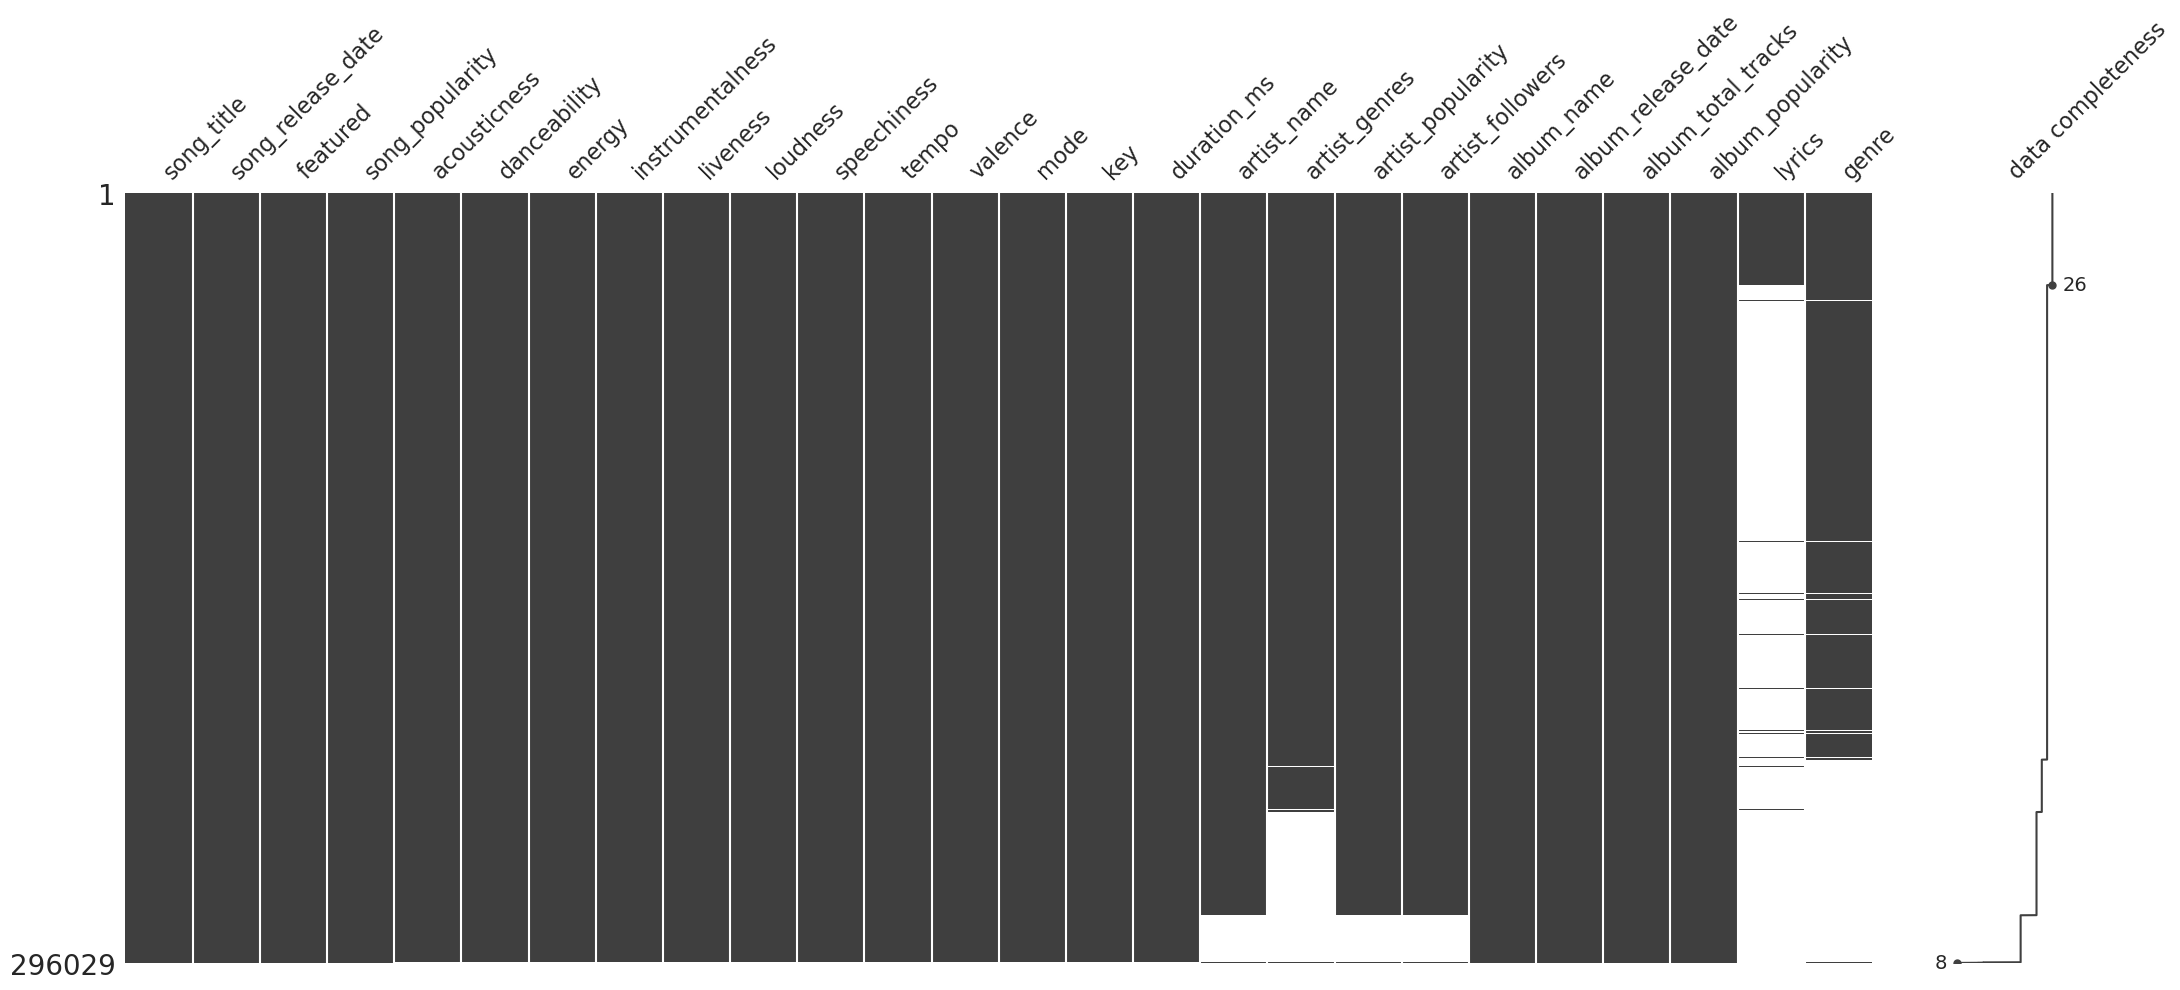

In [12]:
msno.matrix(df_lyrics, labels=True, sort="descending")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Two main objectives: Analysis and the Model

As these two have a little different requirements, I need to work on different parts of the data, first I will definitely drop the records where there is a **lack of the artist info**, especially the genre. After that I need to do a little bit of cleaning in terms of the:<br>

-**release_date**<br>
-**genres**<br><br>

I want to perform the analysis only on the songs with popularity >= 5, I don't want some random songs, especially knowing, that I extracted the lyrics only for the songs with popularity greater or equal to 40, So i won't lose any lyrics data.<br>

After dropping the missing values I am left with:<br>

-**178.000** records overall<br>
-**30.600** unique lyrics<br><br>

I found it crucial to drop these values, where the genre was not specified, because it is the most important aspect of the dataset.

In [9]:
df_lyrics = df_lyrics[df_lyrics["song_popularity"] >= 5]

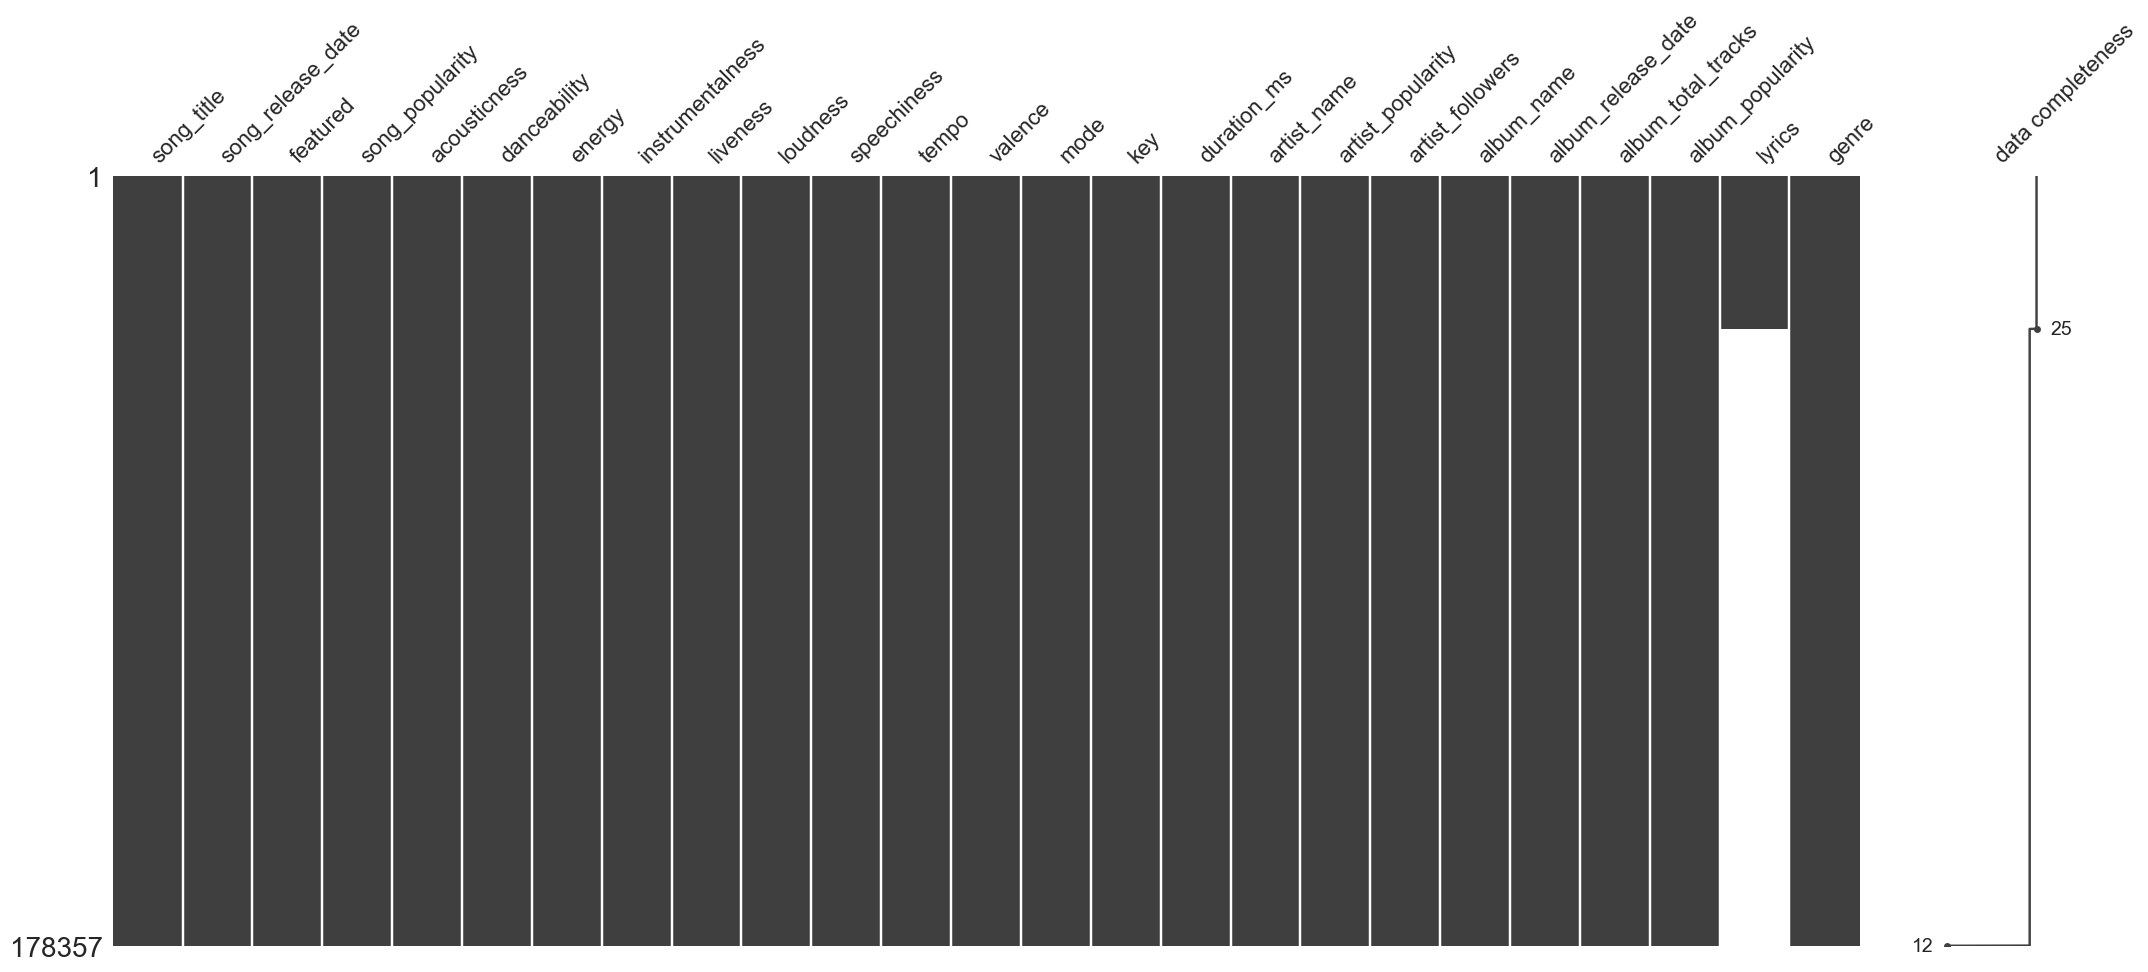

In [10]:
del df_lyrics["artist_genres"]
df_lyrics = df_lyrics.dropna(subset=["genre"])
msno.matrix(df_lyrics, labels=True, sort="descending")
plt.show()

In [21]:
len(df_lyrics["lyrics"].unique())

30683

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### There is no difference between album and song release date
So I need to drop it.

In [11]:
print("Song Release Date != Album Release Date:", len(df_lyrics[df_lyrics["song_release_date"] != df_lyrics["album_release_date"]]))
del df_lyrics["album_release_date"]

Song Release Date != Album Release Date: 0


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Release date - feature extraction

I am going to extract the **Week day** and **Release Year** from release_date, only if it is possible!

In [19]:
dictionary = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

day_of_week = lambda date, dictionary: dictionary[datetime.strptime(date, "%Y-%m-%d").weekday()]

exact_date_precision = df_lyrics["song_release_date"].str.len() == 10

df_lyrics.loc[exact_date_precision, "day_of_week"] = df_lyrics.loc[exact_date_precision, "song_release_date"].apply(lambda x: day_of_week(x, dictionary))
df_lyrics["release_year"] = df_lyrics["song_release_date"].str[:4]

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Let's change duration's metric to seconds

In [21]:
df_lyrics["duration"] = df_lyrics["duration_ms"] // 1000
del df_lyrics["duration_ms"]

In [23]:
df_lyrics.head(3)

song_title song_release_date  featured  \
1  It's All Over Now - Mono Version        1964-10-17         0   
3                         It's Over              1962         0   
4                            Ramona        2015-05-07         0   

   song_popularity  acousticness  danceability  energy  instrumentalness  \
1               47        0.0235         0.603   0.689          0.000003   
3               44        0.7400         0.462   0.319          0.000758   
4               18        0.4800         0.679   0.422          0.000031   

   liveness  loudness  ...  artist_popularity  artist_followers  \
1    0.3300   -10.729  ...               79.0        14083807.0   
3    0.0803   -12.448  ...               68.0         2024651.0   
4    0.1540   -10.860  ...               37.0           39741.0   

         album_name  album_total_tracks  album_popularity  \
1            12 X 5                  12                45   
3  Oh, Pretty Woman                  12                71   
4    The Collection                  25                30   

                                              lyrics  genre  day_of_week  \
1   Well, baby used to stay out all night long Sh...   rock     Saturday   
3   Your baby doesn't love you anymore  Golden da...   folk          NaN   
4                                                NaN   rock     Thursday   

  release_year  duration  
1         1964     206.0  
3         1962     181.0  
4         2015     160.0  

[3 rows x 26 columns]

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## Let's see what is the nature of each numerical feature



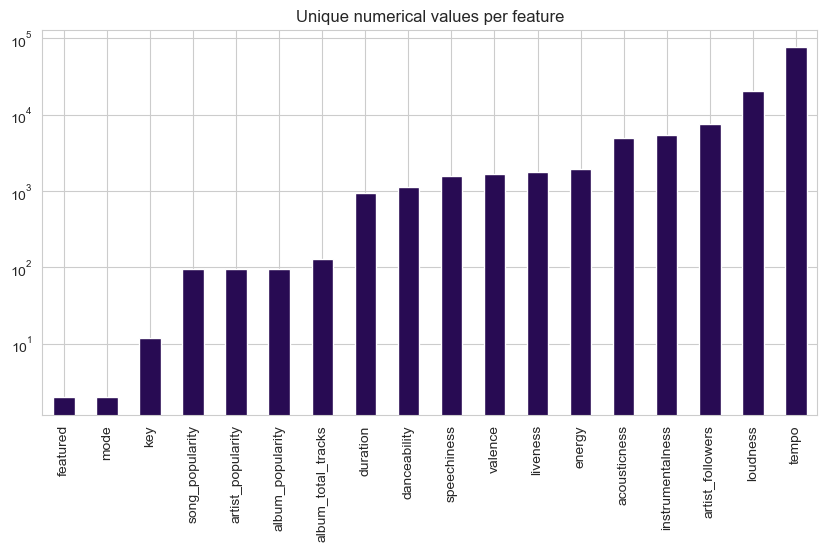

In [35]:
unique_values = df_lyrics.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(figsize=(10,5), title="Unique numerical values per feature", logy=True)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## And now the categorical features



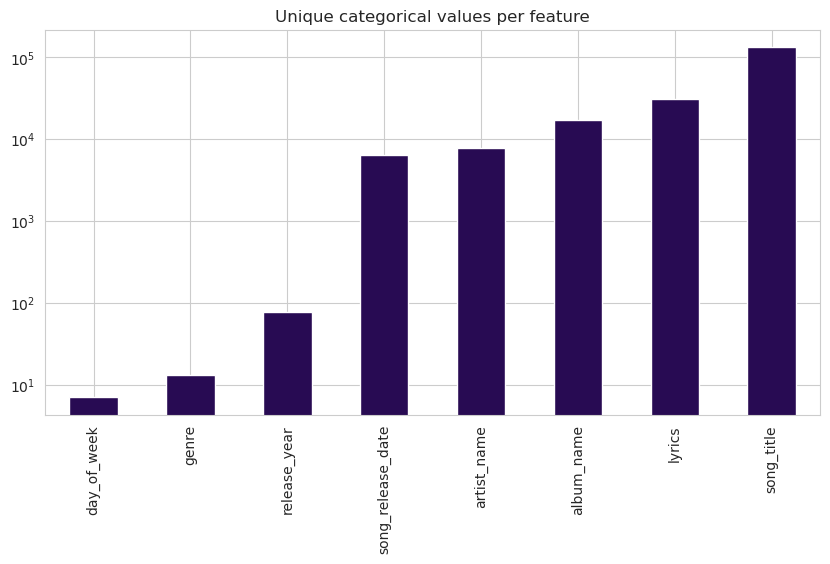

In [21]:
unique_values = df_lyrics.select_dtypes(exclude="number").nunique().sort_values()
unique_values.plot.bar(figsize=(10,5), title="Unique categorical values per feature", logy=True)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## The amount of each genre in dataset

The dataset is **not too balanced** and the map is obviously not perfect, we can see the dominance of **rock, pop, electronical, rap and r&b** genres.
There are a few genres with just a little of the occurences, I need to group them even more tightly into more general groups.



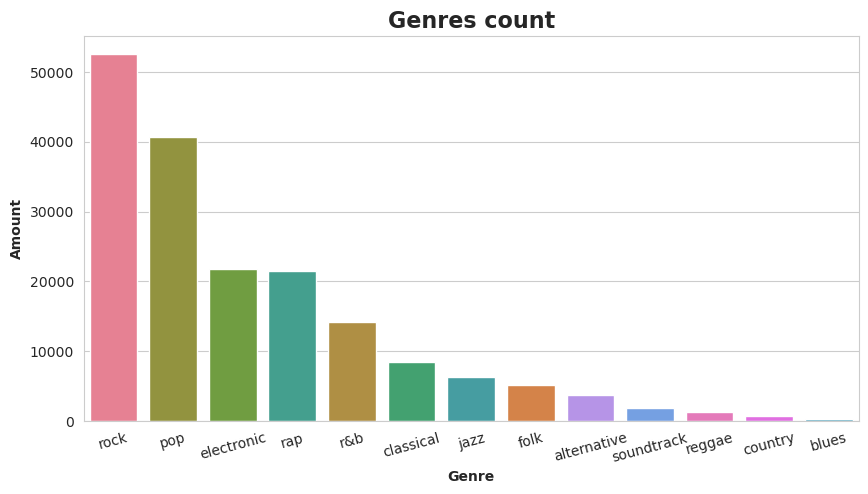

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_lyrics, x="genre", hue="genre",
              order=df_lyrics["genre"].value_counts().index)

plt.title("Genres count", weight="bold", fontsize=16)
plt.xlabel("Genre", weight="bold")
plt.ylabel("Amount", weight="bold")
plt.xticks(rotation=15)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Now let's see how this looks like across years

I want to see whether the data is balanced across years in terms of genres of the records.

It doesn't look the worst.



In [25]:
df_lyrics["release_year"] = df_lyrics["release_year"].astype(int)

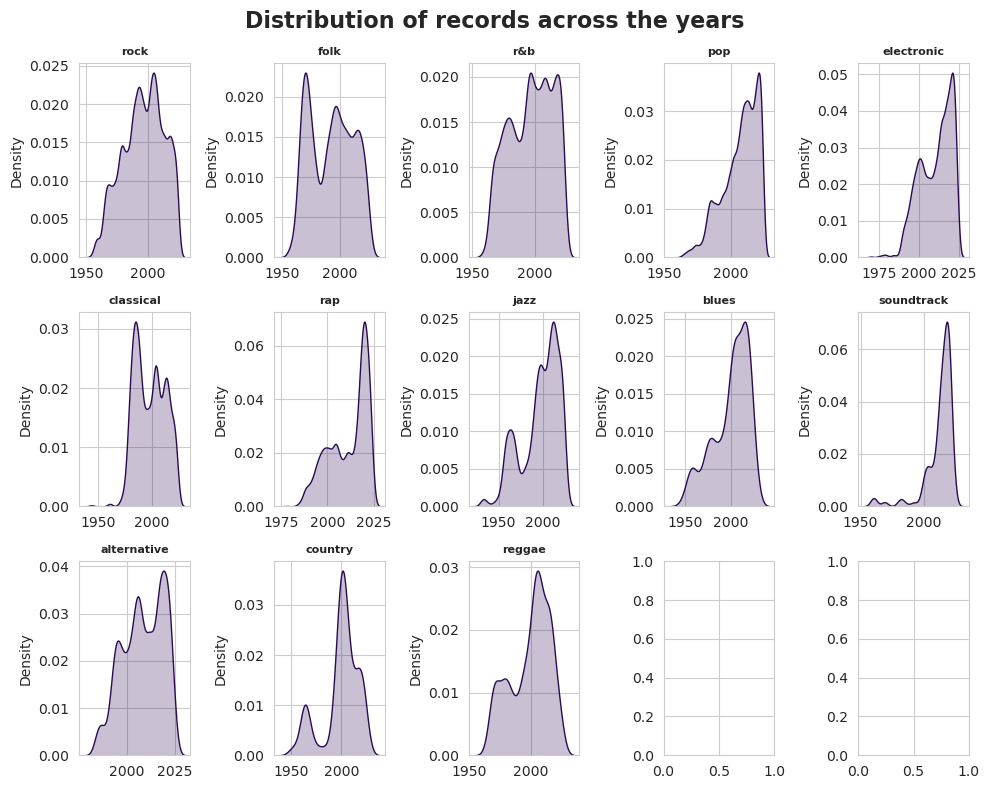

In [24]:
fig, axes = plt.subplots(figsize=(10,8), nrows=3, ncols=5)

for ax, genre in zip(axes.flatten(), df_lyrics["genre"].unique()):
    dat = df_lyrics[df_lyrics["genre"] == genre]
    sns.kdeplot(data=dat, x="release_year", fill=True, ax=ax)
    ax.set_title(genre, weight="bold", fontsize=8)
    ax.set_xlabel("")
fig.suptitle("Distribution of records across the years", weight="bold", fontsize=16)
    
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's have a grasp of how data looks like

Now we can see, that we have one **binary** (mode), and one **ordinary** (key) feature.<br> The rest is numerical, and vary in their values.<br><br>
We can also see a little pattern existing due to the way of data collection methods.



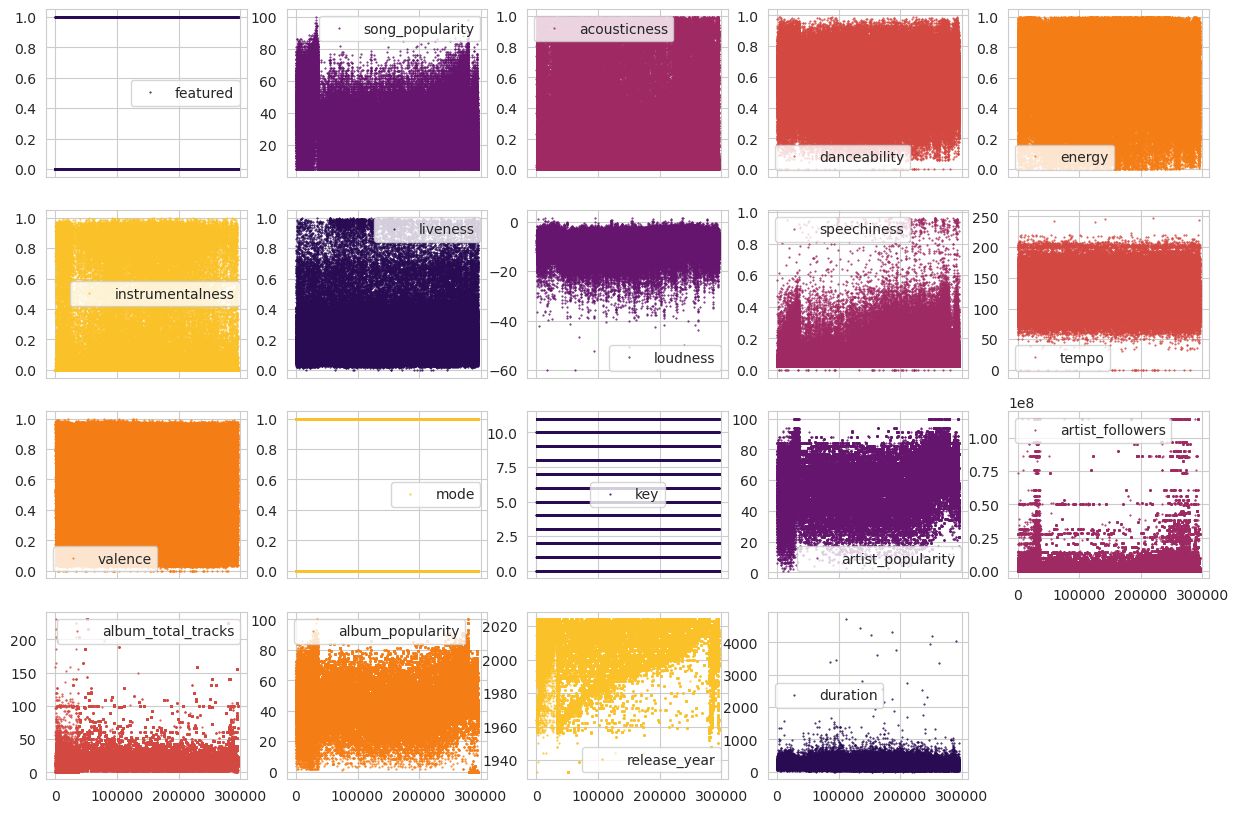

In [25]:
df_lyrics.plot(lw=0, marker=".", subplots=True, layout=(-1,5), figsize=(15,10), markersize=1)
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Most frequent artists in dataset

Wooah! There is almost **1200 Elvis songs** in the dataset!<br>
That's almost 2x more than the second position - **Glee Cast**. I didn't know what the Glee Cast was, until I googled it, and found out it is some sort of **TV Show**.
<br><br>
To be honest, I find it a little bit **suspicious**.
<br>
Let's look at the duplicates then!



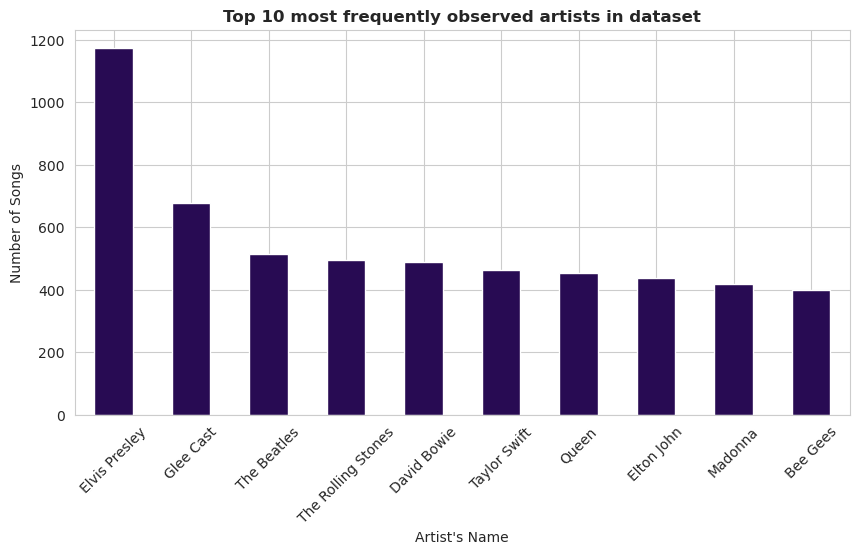

In [26]:
most_frequent_artists = df_lyrics["artist_name"].value_counts().sort_values(ascending=False).head(10)
most_frequent_artists.plot(kind="bar", figsize=(10, 5))
plt.title("Top 10 most frequently observed artists in dataset", weight="bold")
plt.xlabel("Artist's Name")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45)
plt.show()


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's see the duplicates

Yeah, as I supposed - Around **3400 of duplicated entries**, including **Elvis, Madonna and Taylor** from the previous graph.
<br>
Let's get rid of them and continue the analysis.



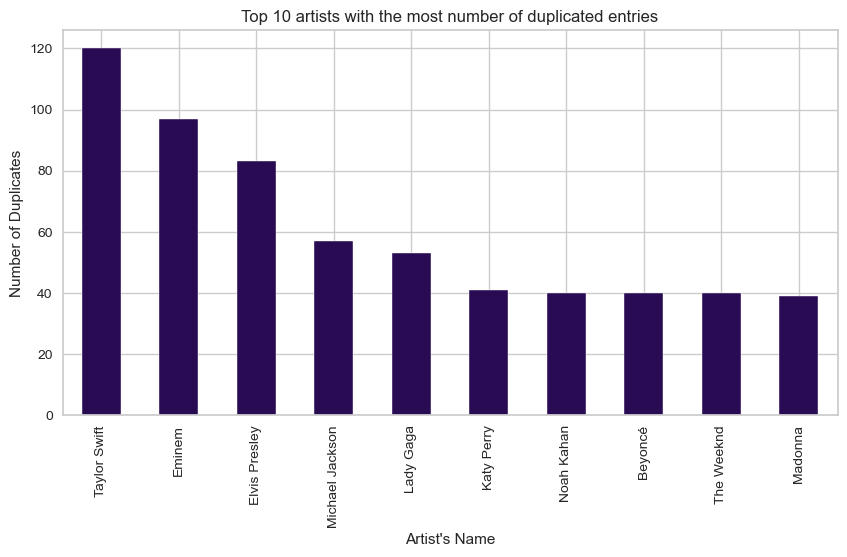

In [27]:
no_duplicates = df_lyrics.drop_duplicates(subset=["song_title", "artist_name"])

duplicates = df_lyrics[~df_lyrics.isin(no_duplicates)].dropna()

duplicates["artist_name"].value_counts().sort_values(ascending=False).head(10).plot(kind="bar", figsize=(10,5))
plt.title("Top 10 artists with the most number of duplicated entries")
plt.xlabel("Artist's Name")
plt.ylabel("Number of Duplicates")
plt.show()

In [42]:
duplicates.shape[0]

3441

In [44]:
len(no_duplicates["lyrics"].unique())

29851

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Let's look at the feature distribution

Ok, so **first insights from the distrubutions:**

- **Strong right skewness** in terms of **speechiness, acousticness, instrumentalness** makes these features inbalanced in this dataset, presenting the songs mostly as the opposites of these metrics.

- Similiar situation is found in **liveness**, however the effect is not as strong as in the previously mentioned features.

- The overall **release_year** distribution looks linear, having mostly the new songs, but it is not that bad to be honest.

- In terms of duration, number of total tracks in the album and the number of artist's followers, it does not really matter here.


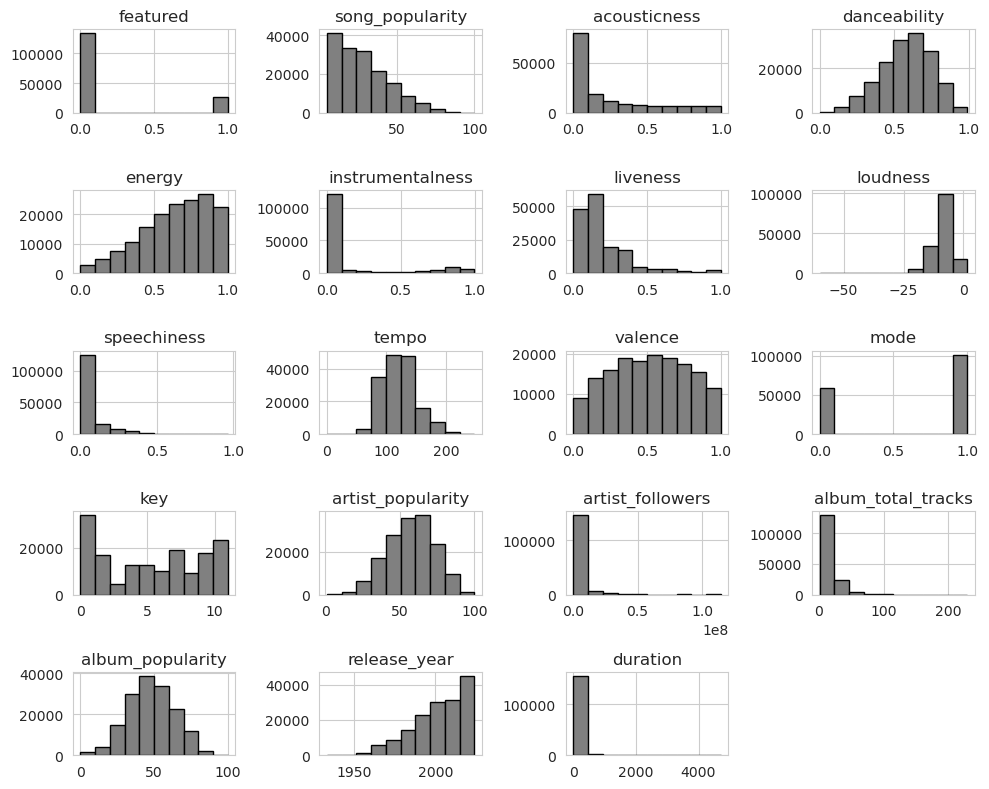

In [30]:
no_duplicates.hist(figsize=(10,8), layout=(-1,4), edgecolor="black", color="gray", bins=10)
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Ok, let's see the relations between every feature

The **hexbin** will help to locate where the most of the data is located in the scatterplots.


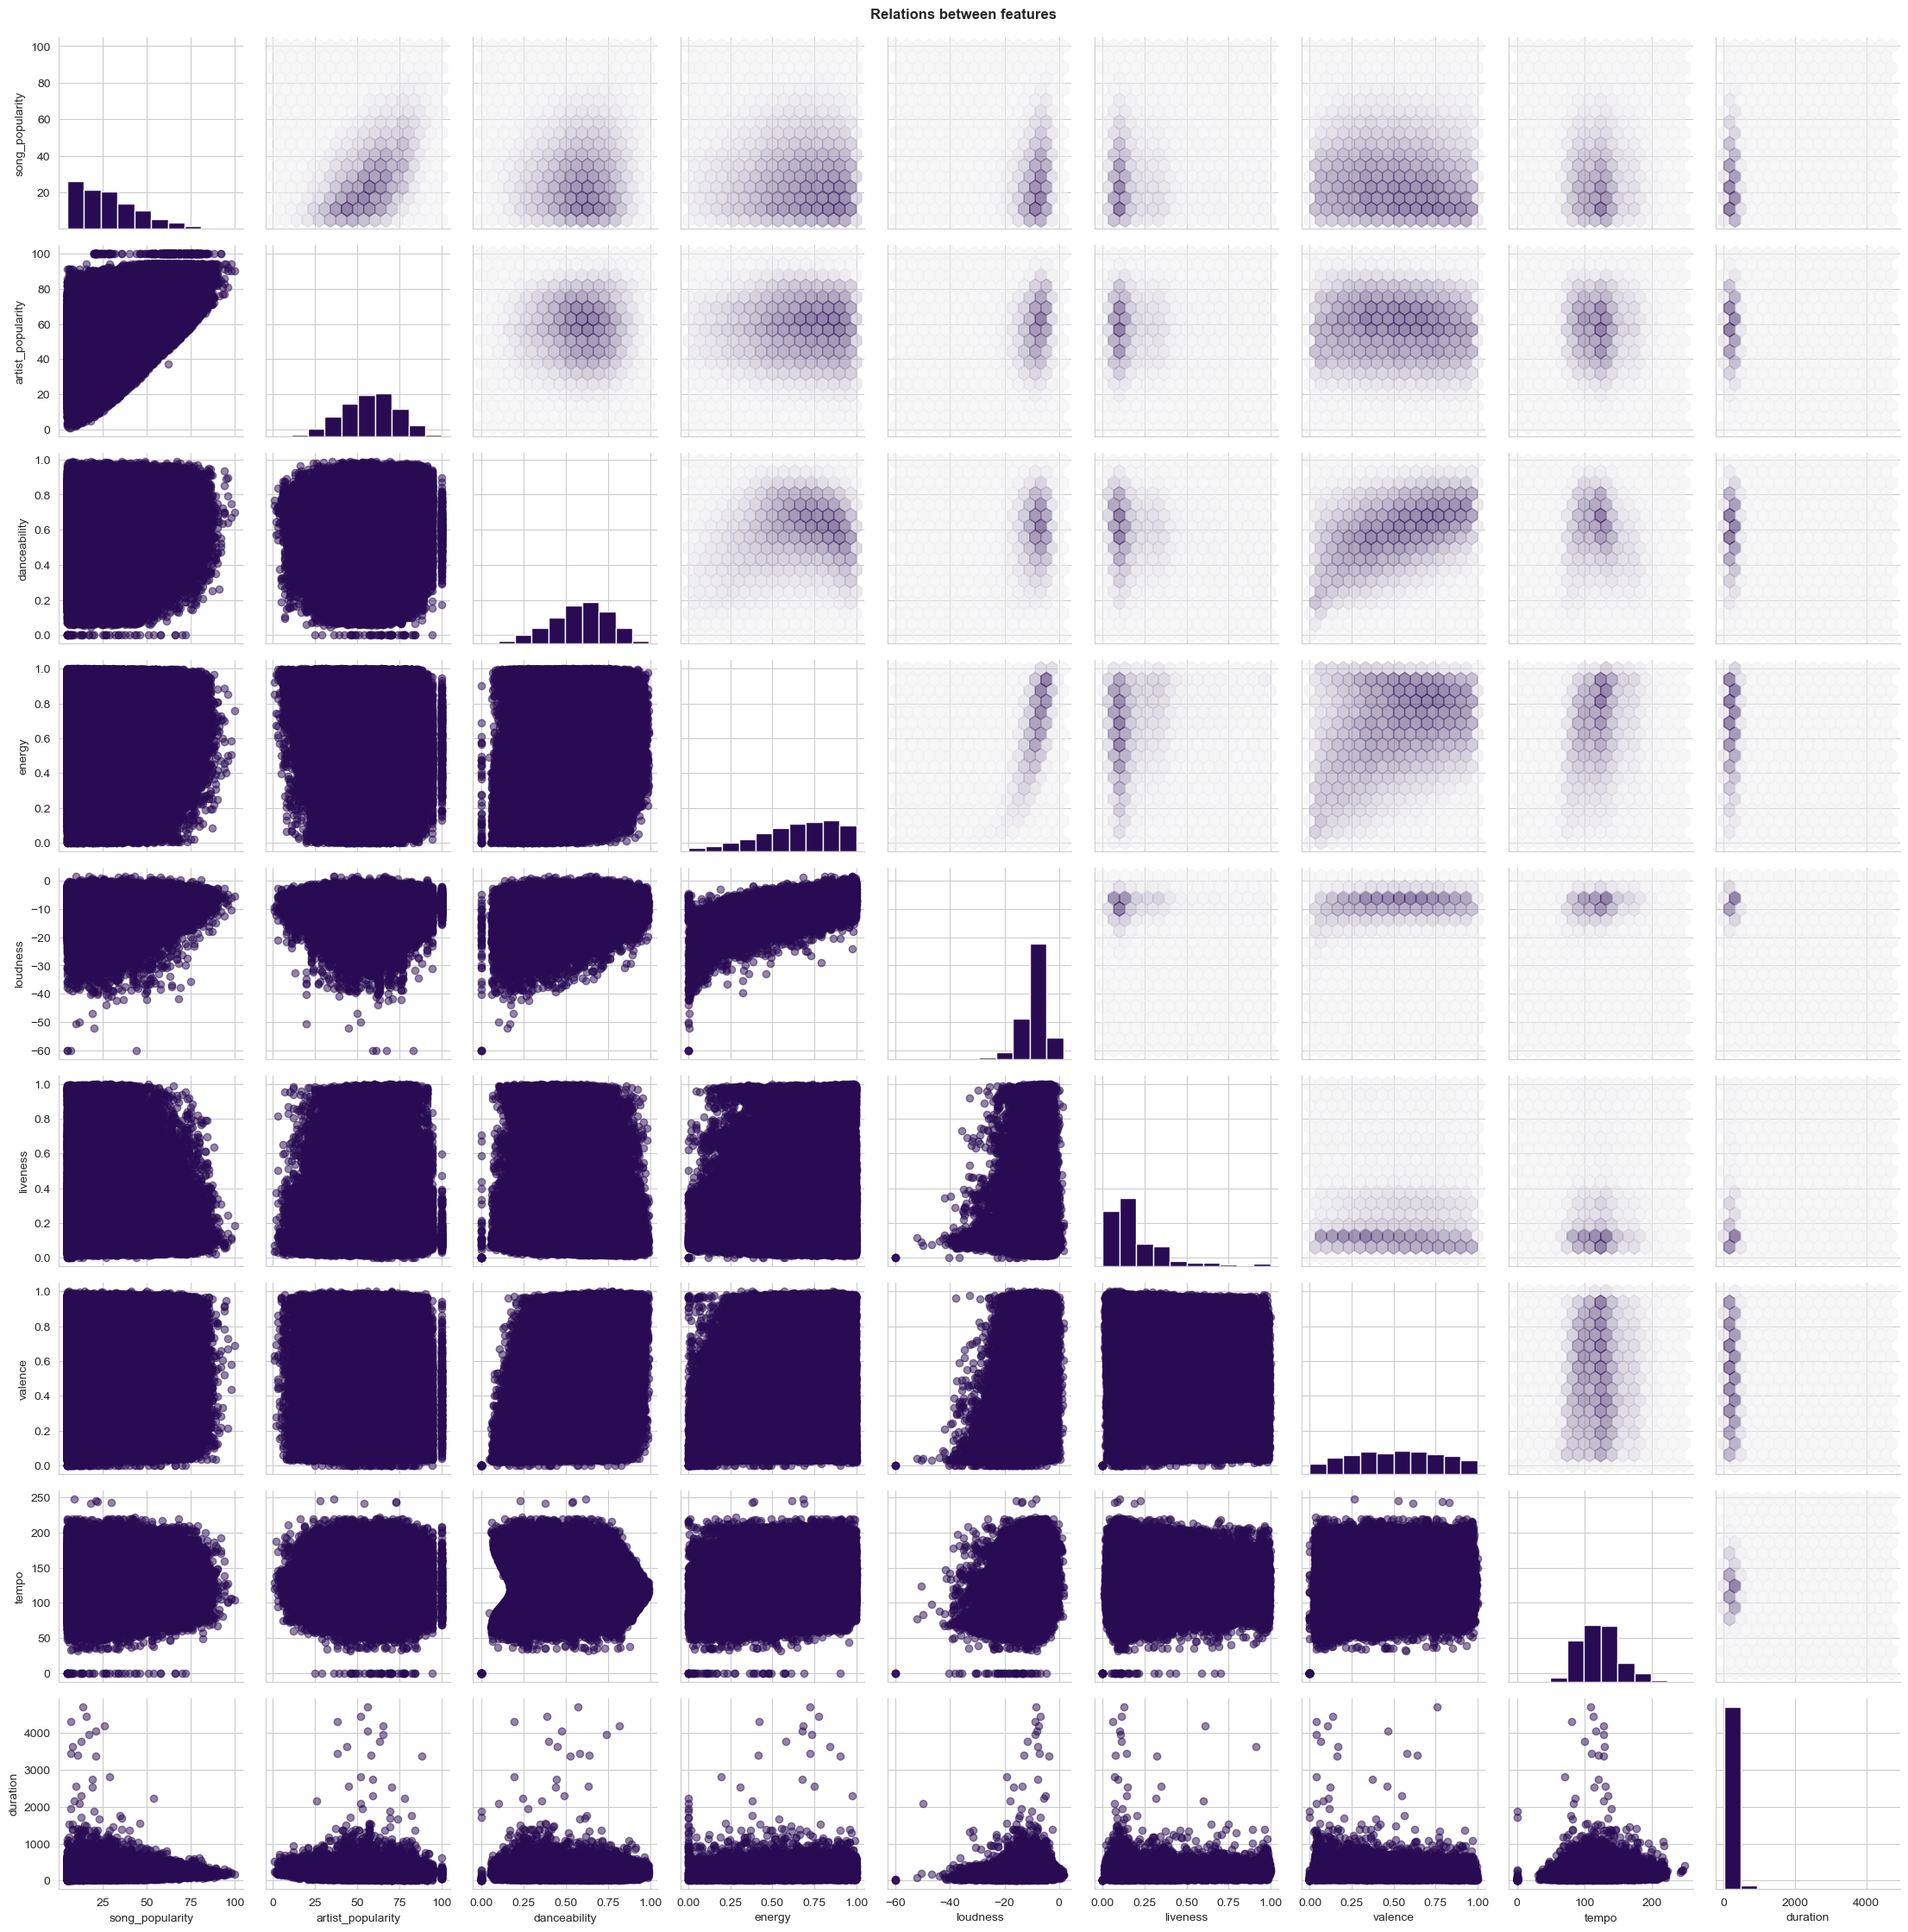

In [46]:
numerical_features = no_duplicates.select_dtypes(include="number").nunique() > 12
data_continous = no_duplicates[numerical_features[numerical_features].index]

def hex_pairplot(data, vars=None):

    def hexbin(x, y, color, max_series=None, min_series=None, **kwargs):
        cmap = sns.light_palette(color, as_cmap=True)
        ax = plt.gca()
        xmin, xmax = min_series[x.name], max_series[x.name]
        ymin, ymax = min_series[y.name], max_series[y.name]
        plt.hexbin(x, y, gridsize=15, cmap=cmap, extent=[xmin, xmax, ymin, ymax], **kwargs)
    if vars:
        g = sns.PairGrid(data[vars])
    else:
        g = sns.PairGrid(data)
    g.map_diag(plt.hist)
    g.map_lower(plt.scatter, alpha=0.5)
    g.map_upper(hexbin, min_series=data.min(), max_series=data.max(), alpha=0.5)

    return g

# excluding the strongly skewed features
g = hex_pairplot(data_continous, vars=["song_popularity", "artist_popularity", "danceability", "energy", "loudness", "liveness", "valence", "tempo", "duration"])
g.fig.suptitle("Relations between features", y=1, weight="bold")
plt.show()

In [32]:
corr = no_duplicates.select_dtypes(include="number").corr()

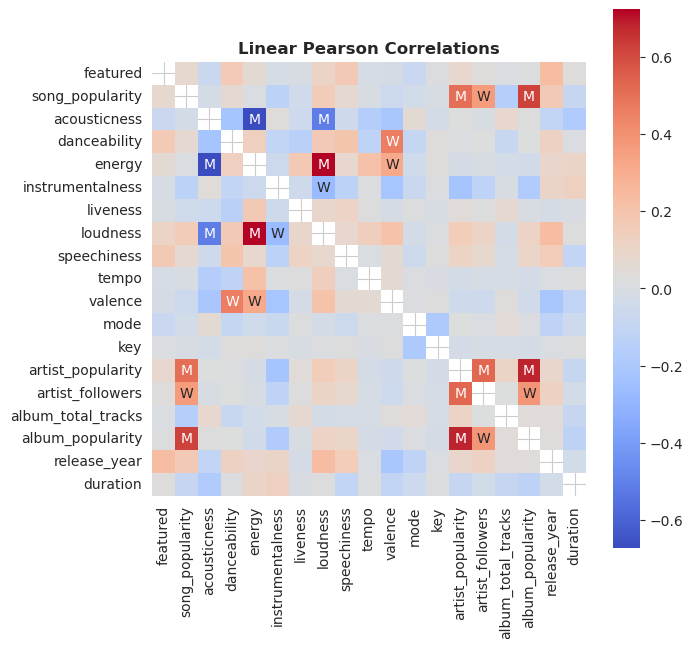

In [33]:
labels = np.where(np.abs(corr)>0.75, "S",
                  np.where(np.abs(corr)>0.5, "M",
                           np.where(np.abs(corr)>0.25, "W", "")))

plt.figure(figsize=(7,7))
sns.heatmap(corr, mask=np.eye(len(corr)),
            square=True, annot=labels, fmt='',
            cmap="coolwarm")
plt.title("Linear Pearson Correlations", weight="bold")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# How different features changed over time

Looking at the songs after 1969, there are a few interesting things to be investigated:<br>

-**Recent decreasing average duration**<br>

-**Decreasing loudness**<br>

-**Decreasing valence**<br>

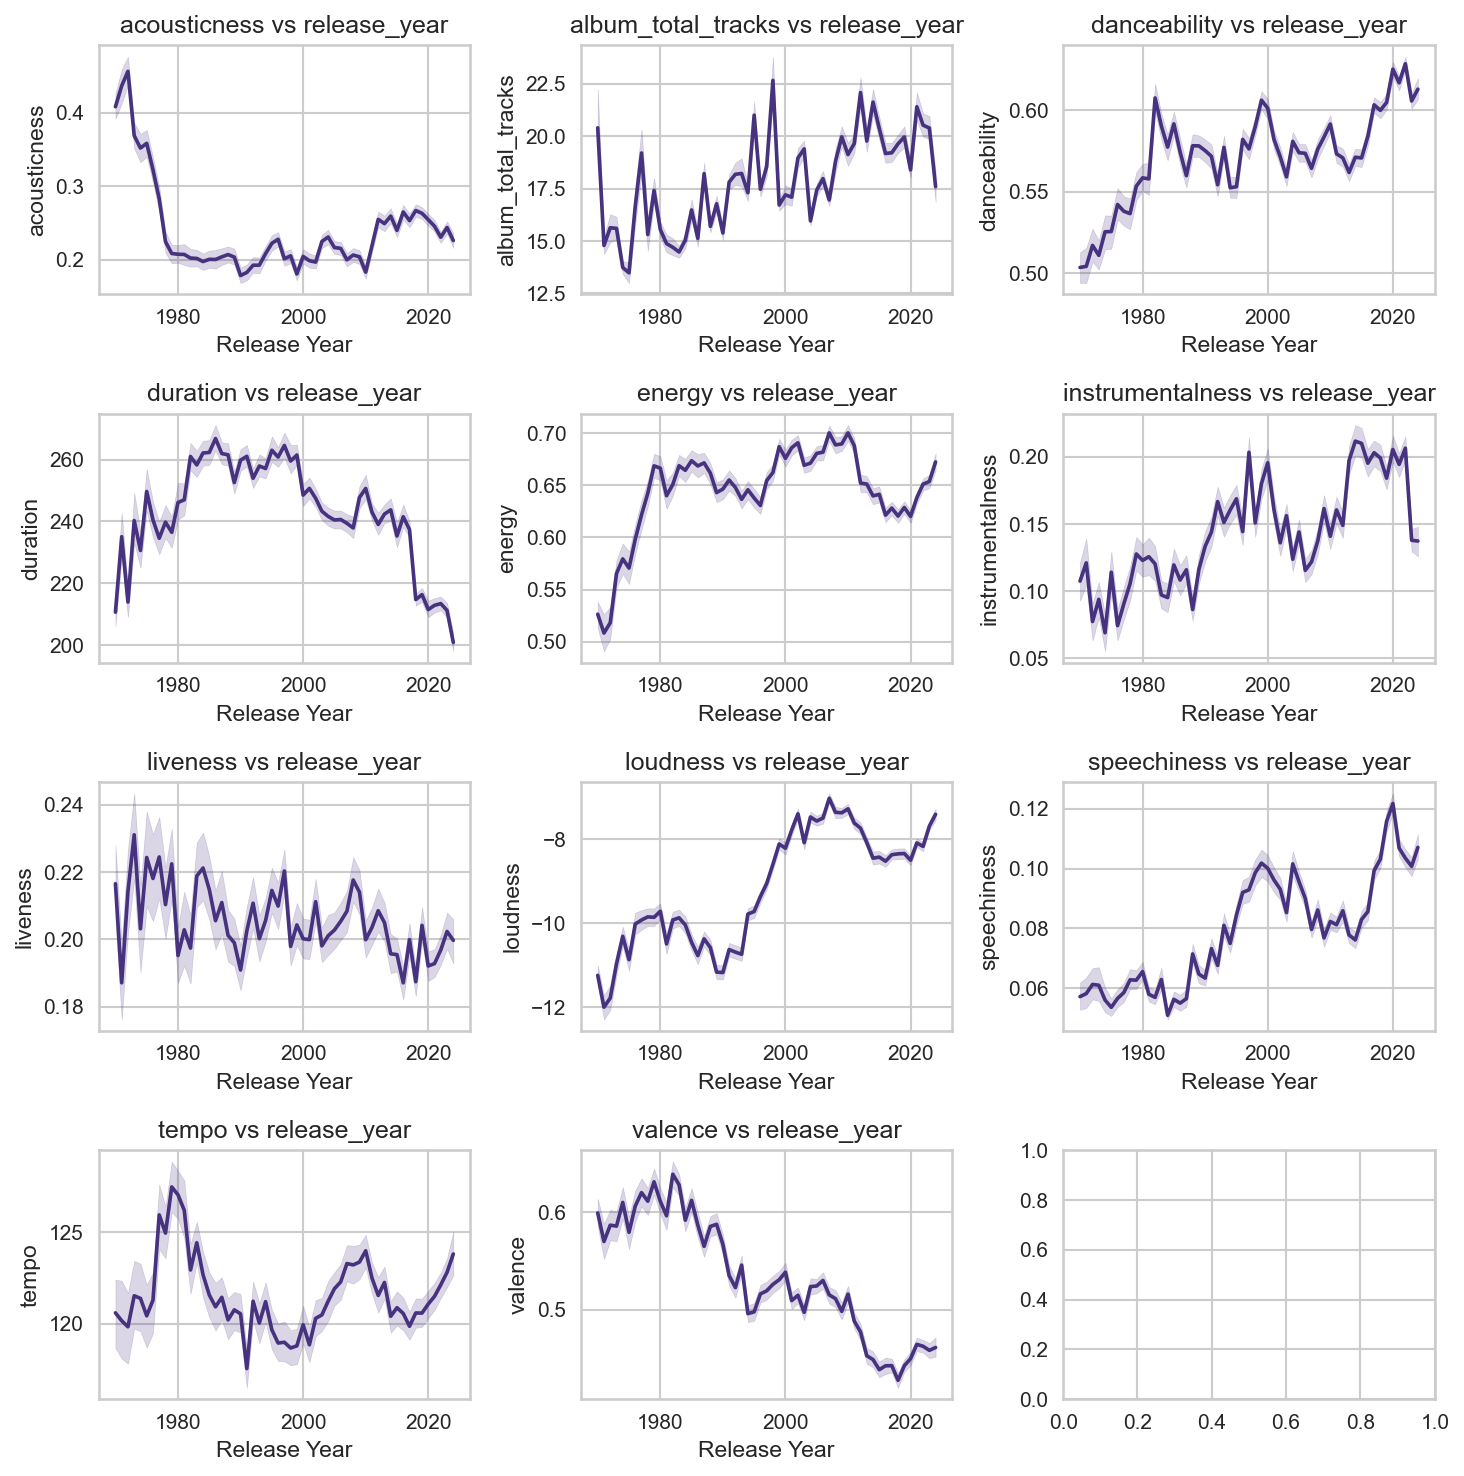

In [55]:
columns = no_duplicates.select_dtypes("number").columns.difference(['release_year', 'key', 'mode', 'featured', 'song_popularity', 'album_popularity', 'artist_followers', 'artist_popularity'])
fig, axes = plt.subplots(figsize=(10,10), nrows=4, ncols=3, dpi=150)

df_1970 = no_duplicates[no_duplicates["release_year"] >= 1970]


for ax, col in zip(axes.flatten(), columns):
    sns.lineplot(data=df_1970, x='release_year', y=col, ax=ax)
    ax.set_title(f'{col} vs release_year')
    ax.set_xlabel('Release Year')
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Songs duration across years and genres

---

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### First let's look at the overall duration across genres

I am going to skip the outliers here for a while.<br><br>

Look's like the longest songs are **electronic**, and on average **soundtracks** are the shortest.

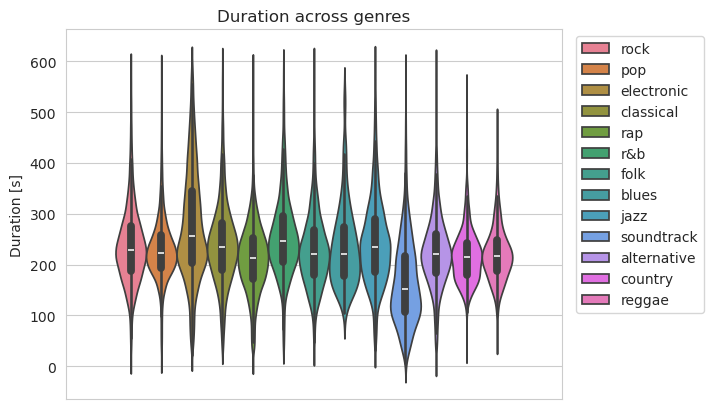

In [35]:
sns.violinplot(data=df_1970[df_1970["duration"] < 600], y="duration", hue="genre")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Duration across genres")
plt.ylabel("Duration [s]")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Duration behaviour over years

There is only one obvious decrease in **rap** genre.

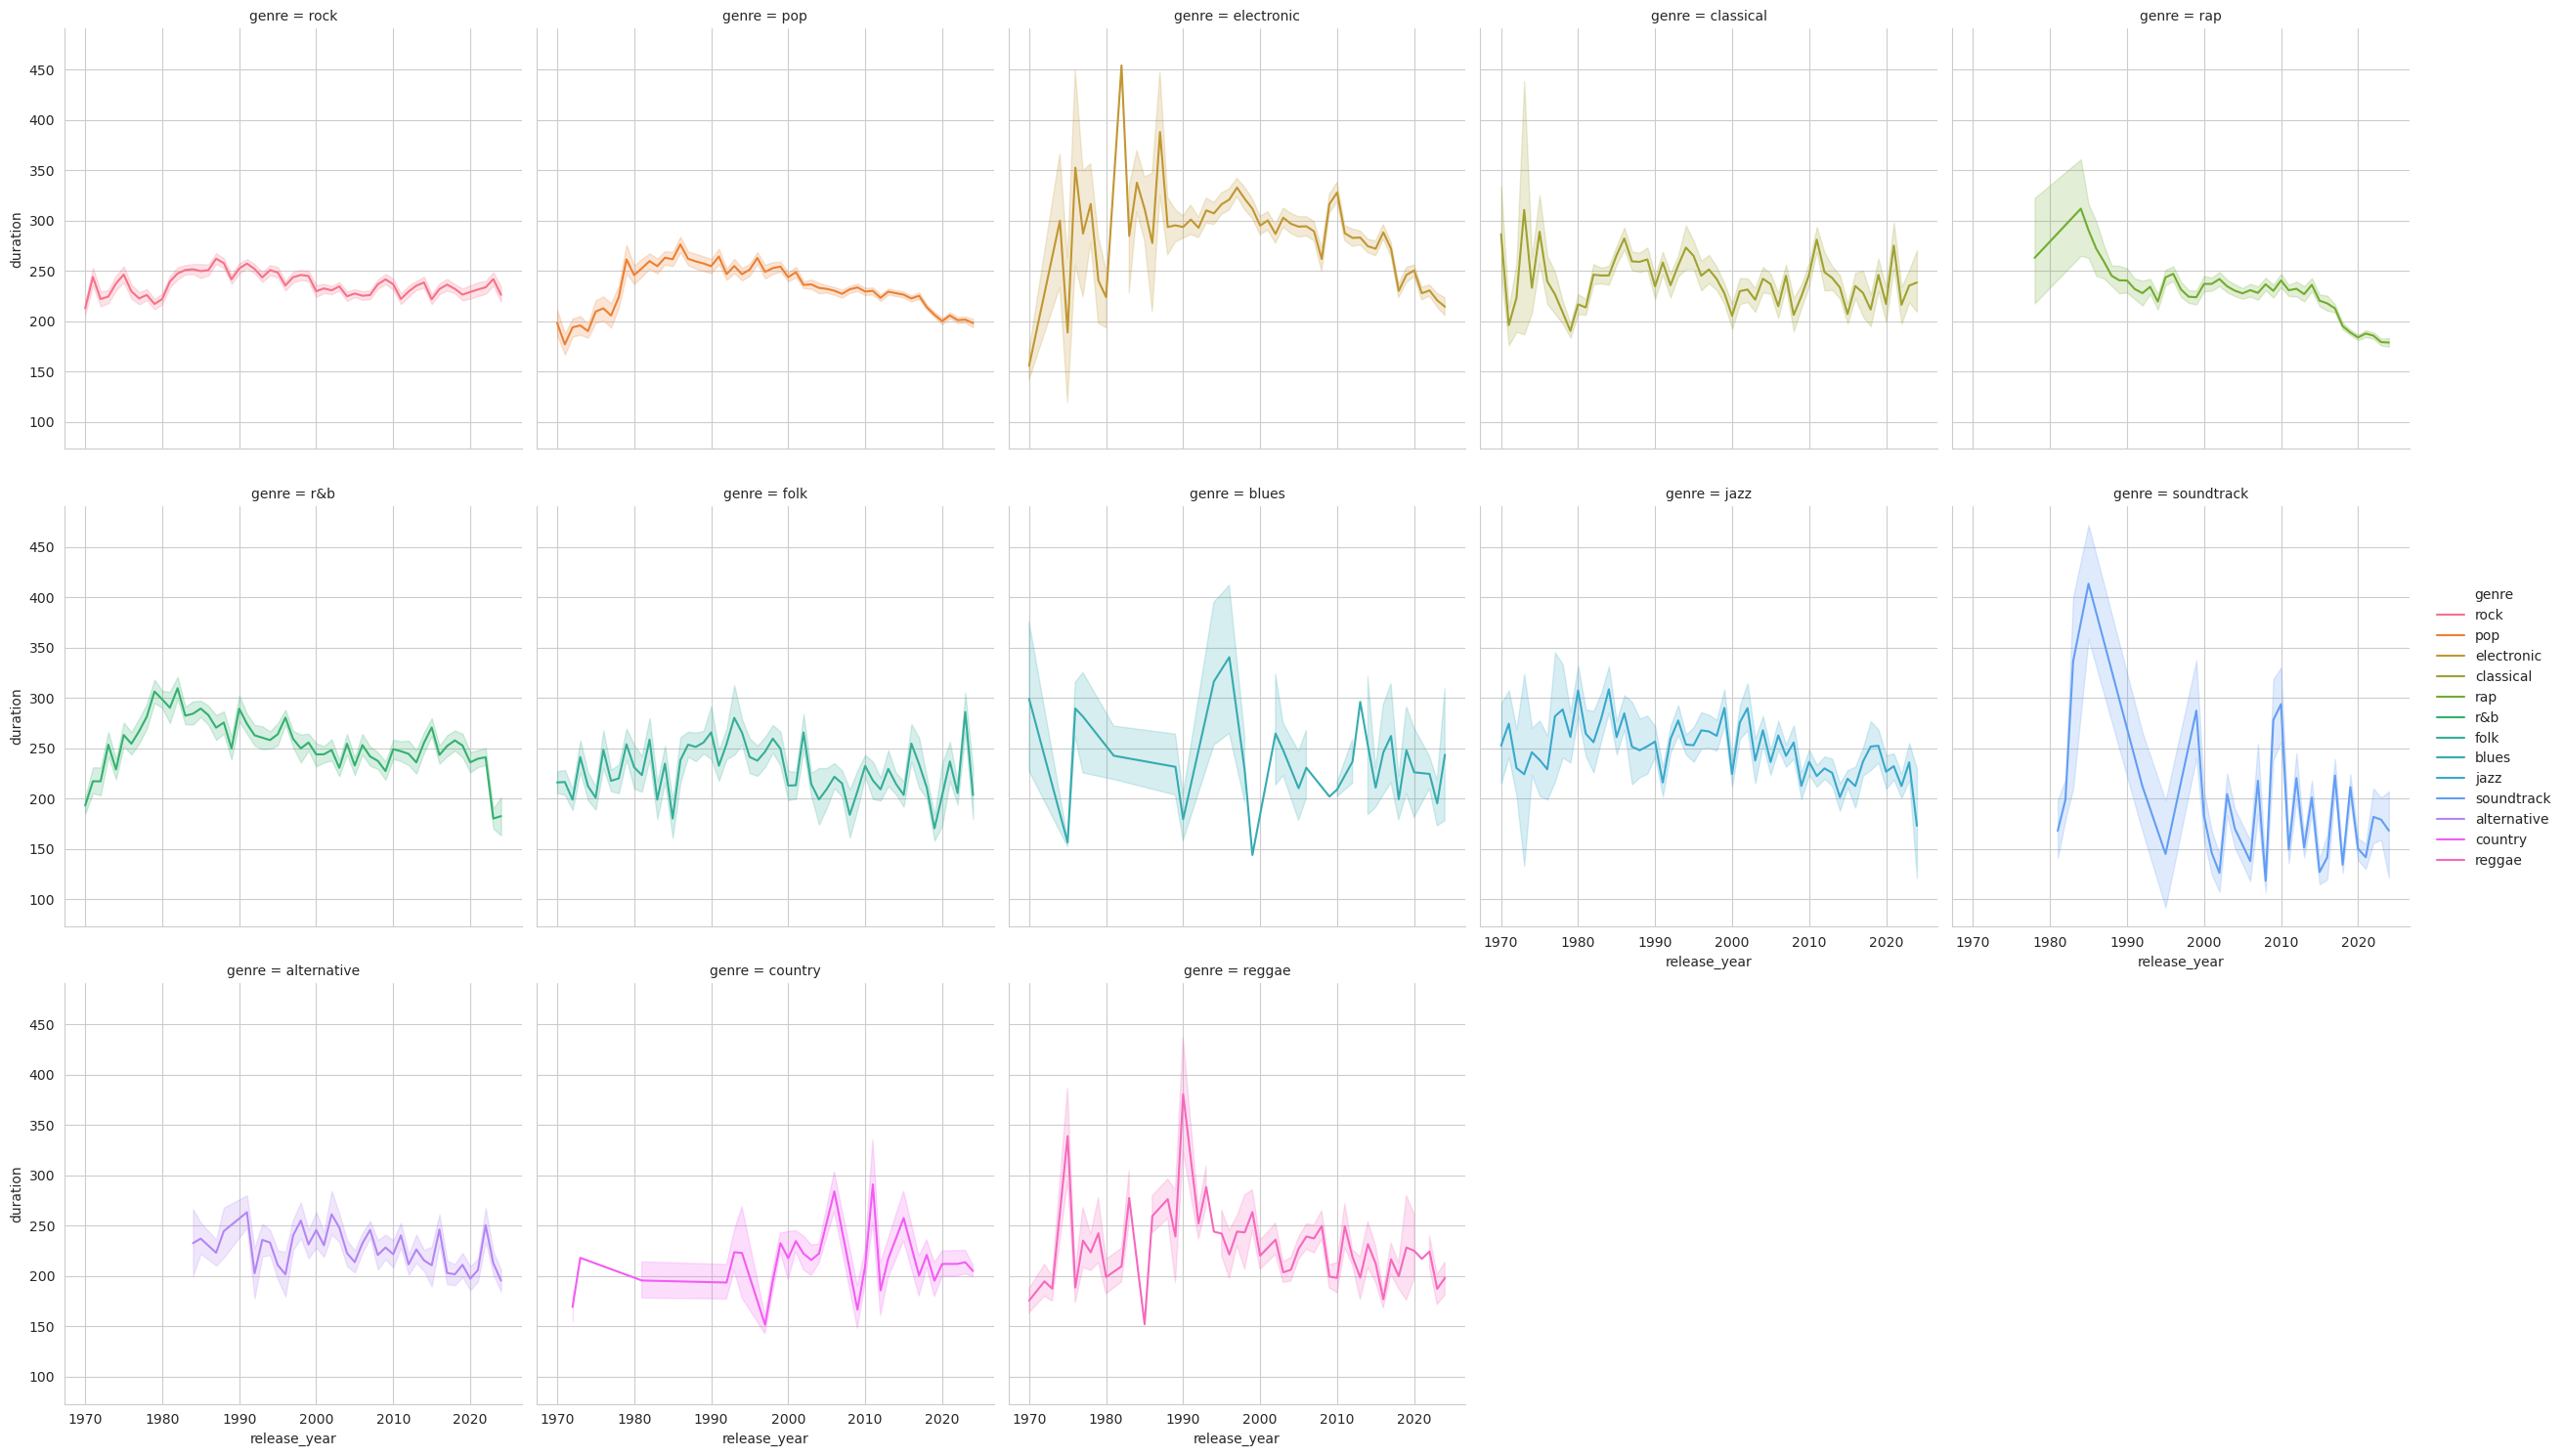

In [36]:
sns.relplot(data=df_1970[df_1970["duration"] < 600], x="release_year", y="duration", col="genre", col_wrap=5, hue="genre", kind="line")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# What about decreasing loudness?

It seems to be beneficial for our hearing systems.

---

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Let's also see some statistics across genres

**Folk, Classical music and Soundtracks** seem to be louder than other genres in general. <br>

However **Rock, Electronic and Alternative** varies more and have some records with extremely high loudness.

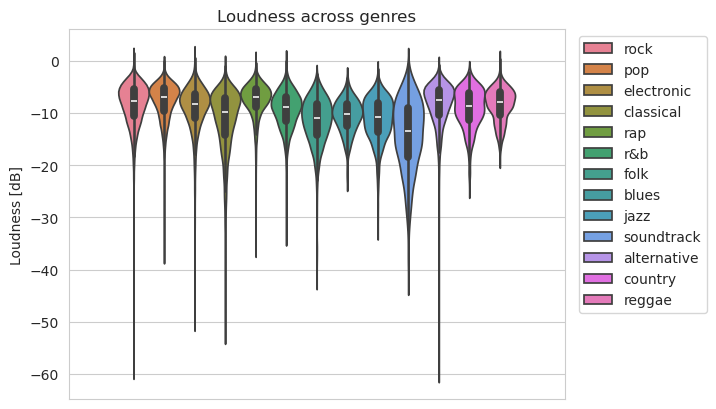

In [37]:
sns.violinplot(data=df_1970, y="loudness", hue="genre")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Loudness across genres")
plt.ylabel("Loudness [dB]")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Constant improvement - except of Classical music

Classical music is the only genre with **increasing** mean loudness with years. 

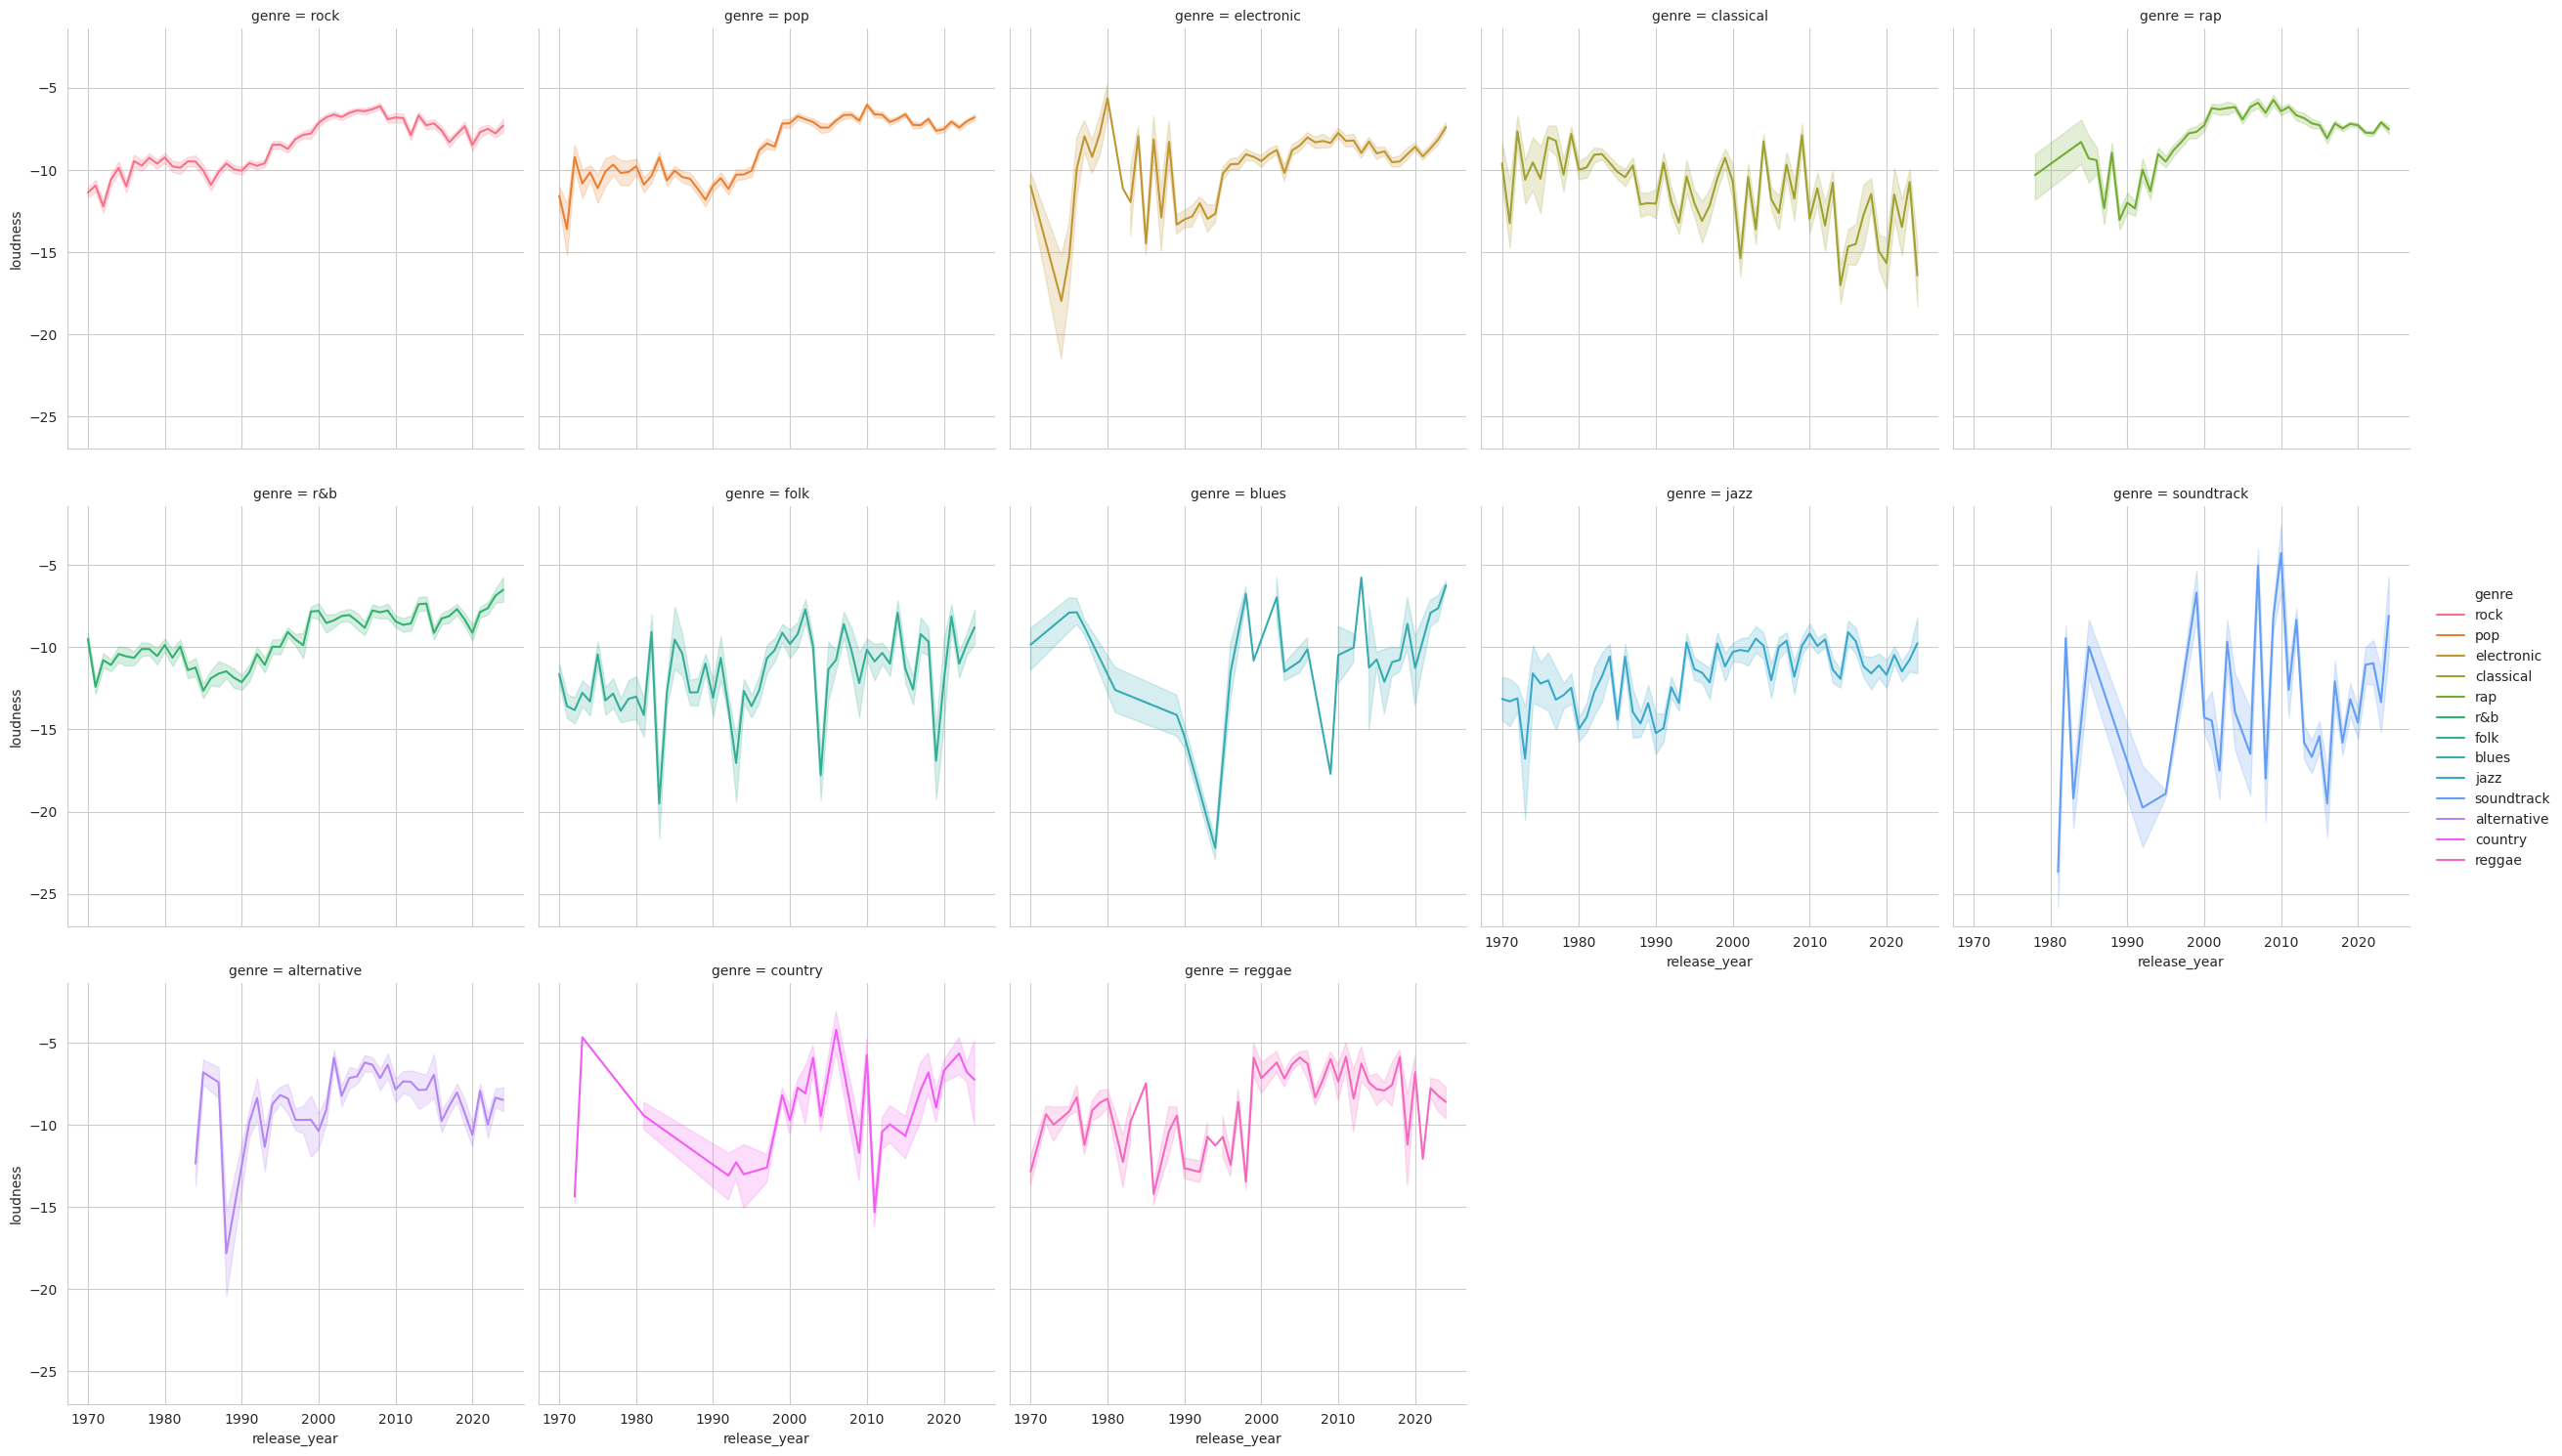

In [38]:
sns.relplot(data=df_1970, x="release_year", y="loudness", col="genre", col_wrap=5, hue="genre", kind="line")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# More and more negative sentiment

Valence seems to be decreasing with passing years. Let's see if we can find something interesting.

---

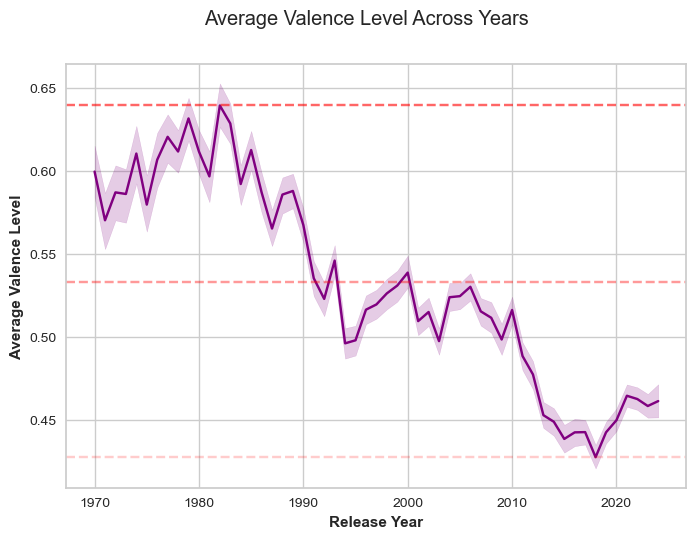

In [149]:
fig = plt.figure()

avg_valence = df_1970.groupby("release_year")["valence"].mean()

sns.lineplot(data=df_1970, x="release_year", y="valence", color="purple")
plt.axhline(y=avg_valence.max(), alpha=0.6, c="red", linestyle="--")
plt.axhline(y=avg_valence.min(), alpha=0.2, c="red", linestyle="--")
plt.axhline(y=avg_valence.mean(), alpha=0.4, c="red", linestyle="--")
plt.xlabel("Release Year", weight="bold")
plt.ylabel("Average Valence Level", weight="bold")
fig.suptitle("Average Valence Level Across Years")
plt.show()
fig.savefig("figures/valence_levels.png")

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Listen to Reggae and R&B!

These two genres with the highest mean valence are less likely to make you feel depressed. 

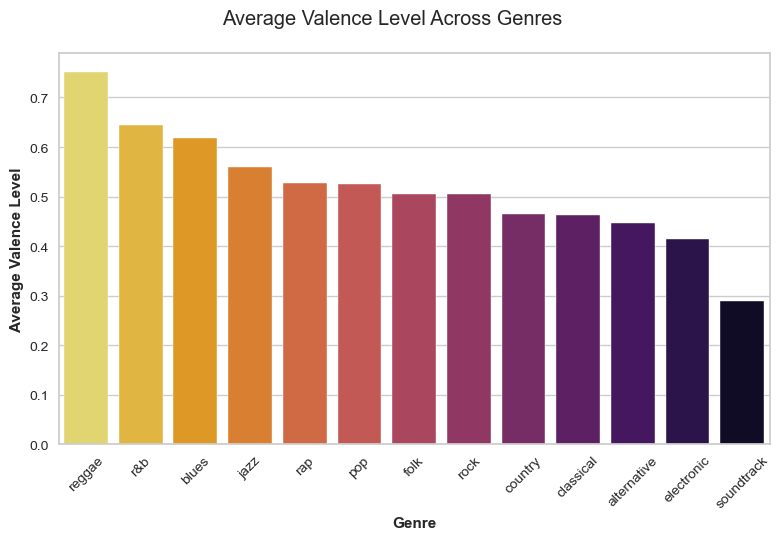

In [277]:
mean_valence_genres = df_1970.groupby("genre")["valence"].mean().reset_index().sort_values(by="valence", ascending=False)

fig = plt.figure()

sns.barplot(data=mean_valence_genres, x="genre", y="valence", hue="genre", palette="inferno_r")
plt.xticks(rotation=45)
plt.xlabel("Genre", weight="bold")
plt.ylabel("Average Valence Level", weight="bold")
fig.suptitle("Average Valence Level Across Genres")
plt.tight_layout()
plt.show()
fig.savefig("figures/valence_genres.png")

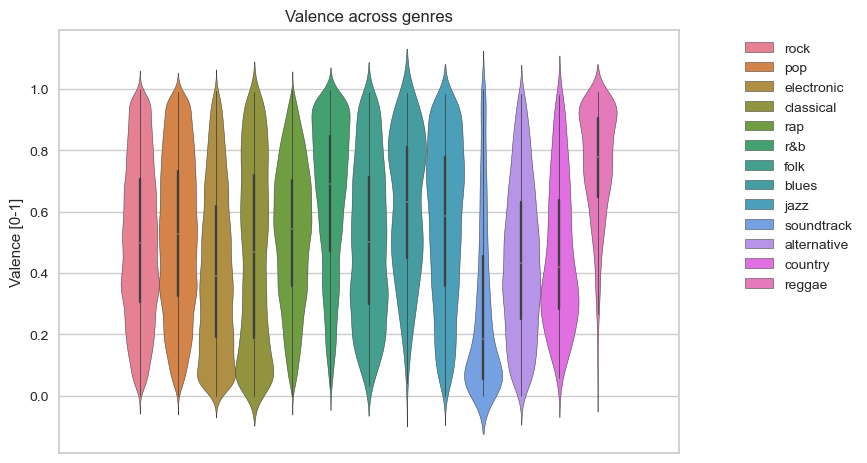

In [153]:
sns.violinplot(data=df_1970, y="valence", hue="genre")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Valence across genres")
plt.ylabel("Valence [0-1]")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

### Slight decreasing trend in every genre

**Rap, Electronic and Pop** are decreasing faster than the others.<br><br>
**R&B** even tough is on average a positive genre, with passing years the valence seems to be decreasing also in here!

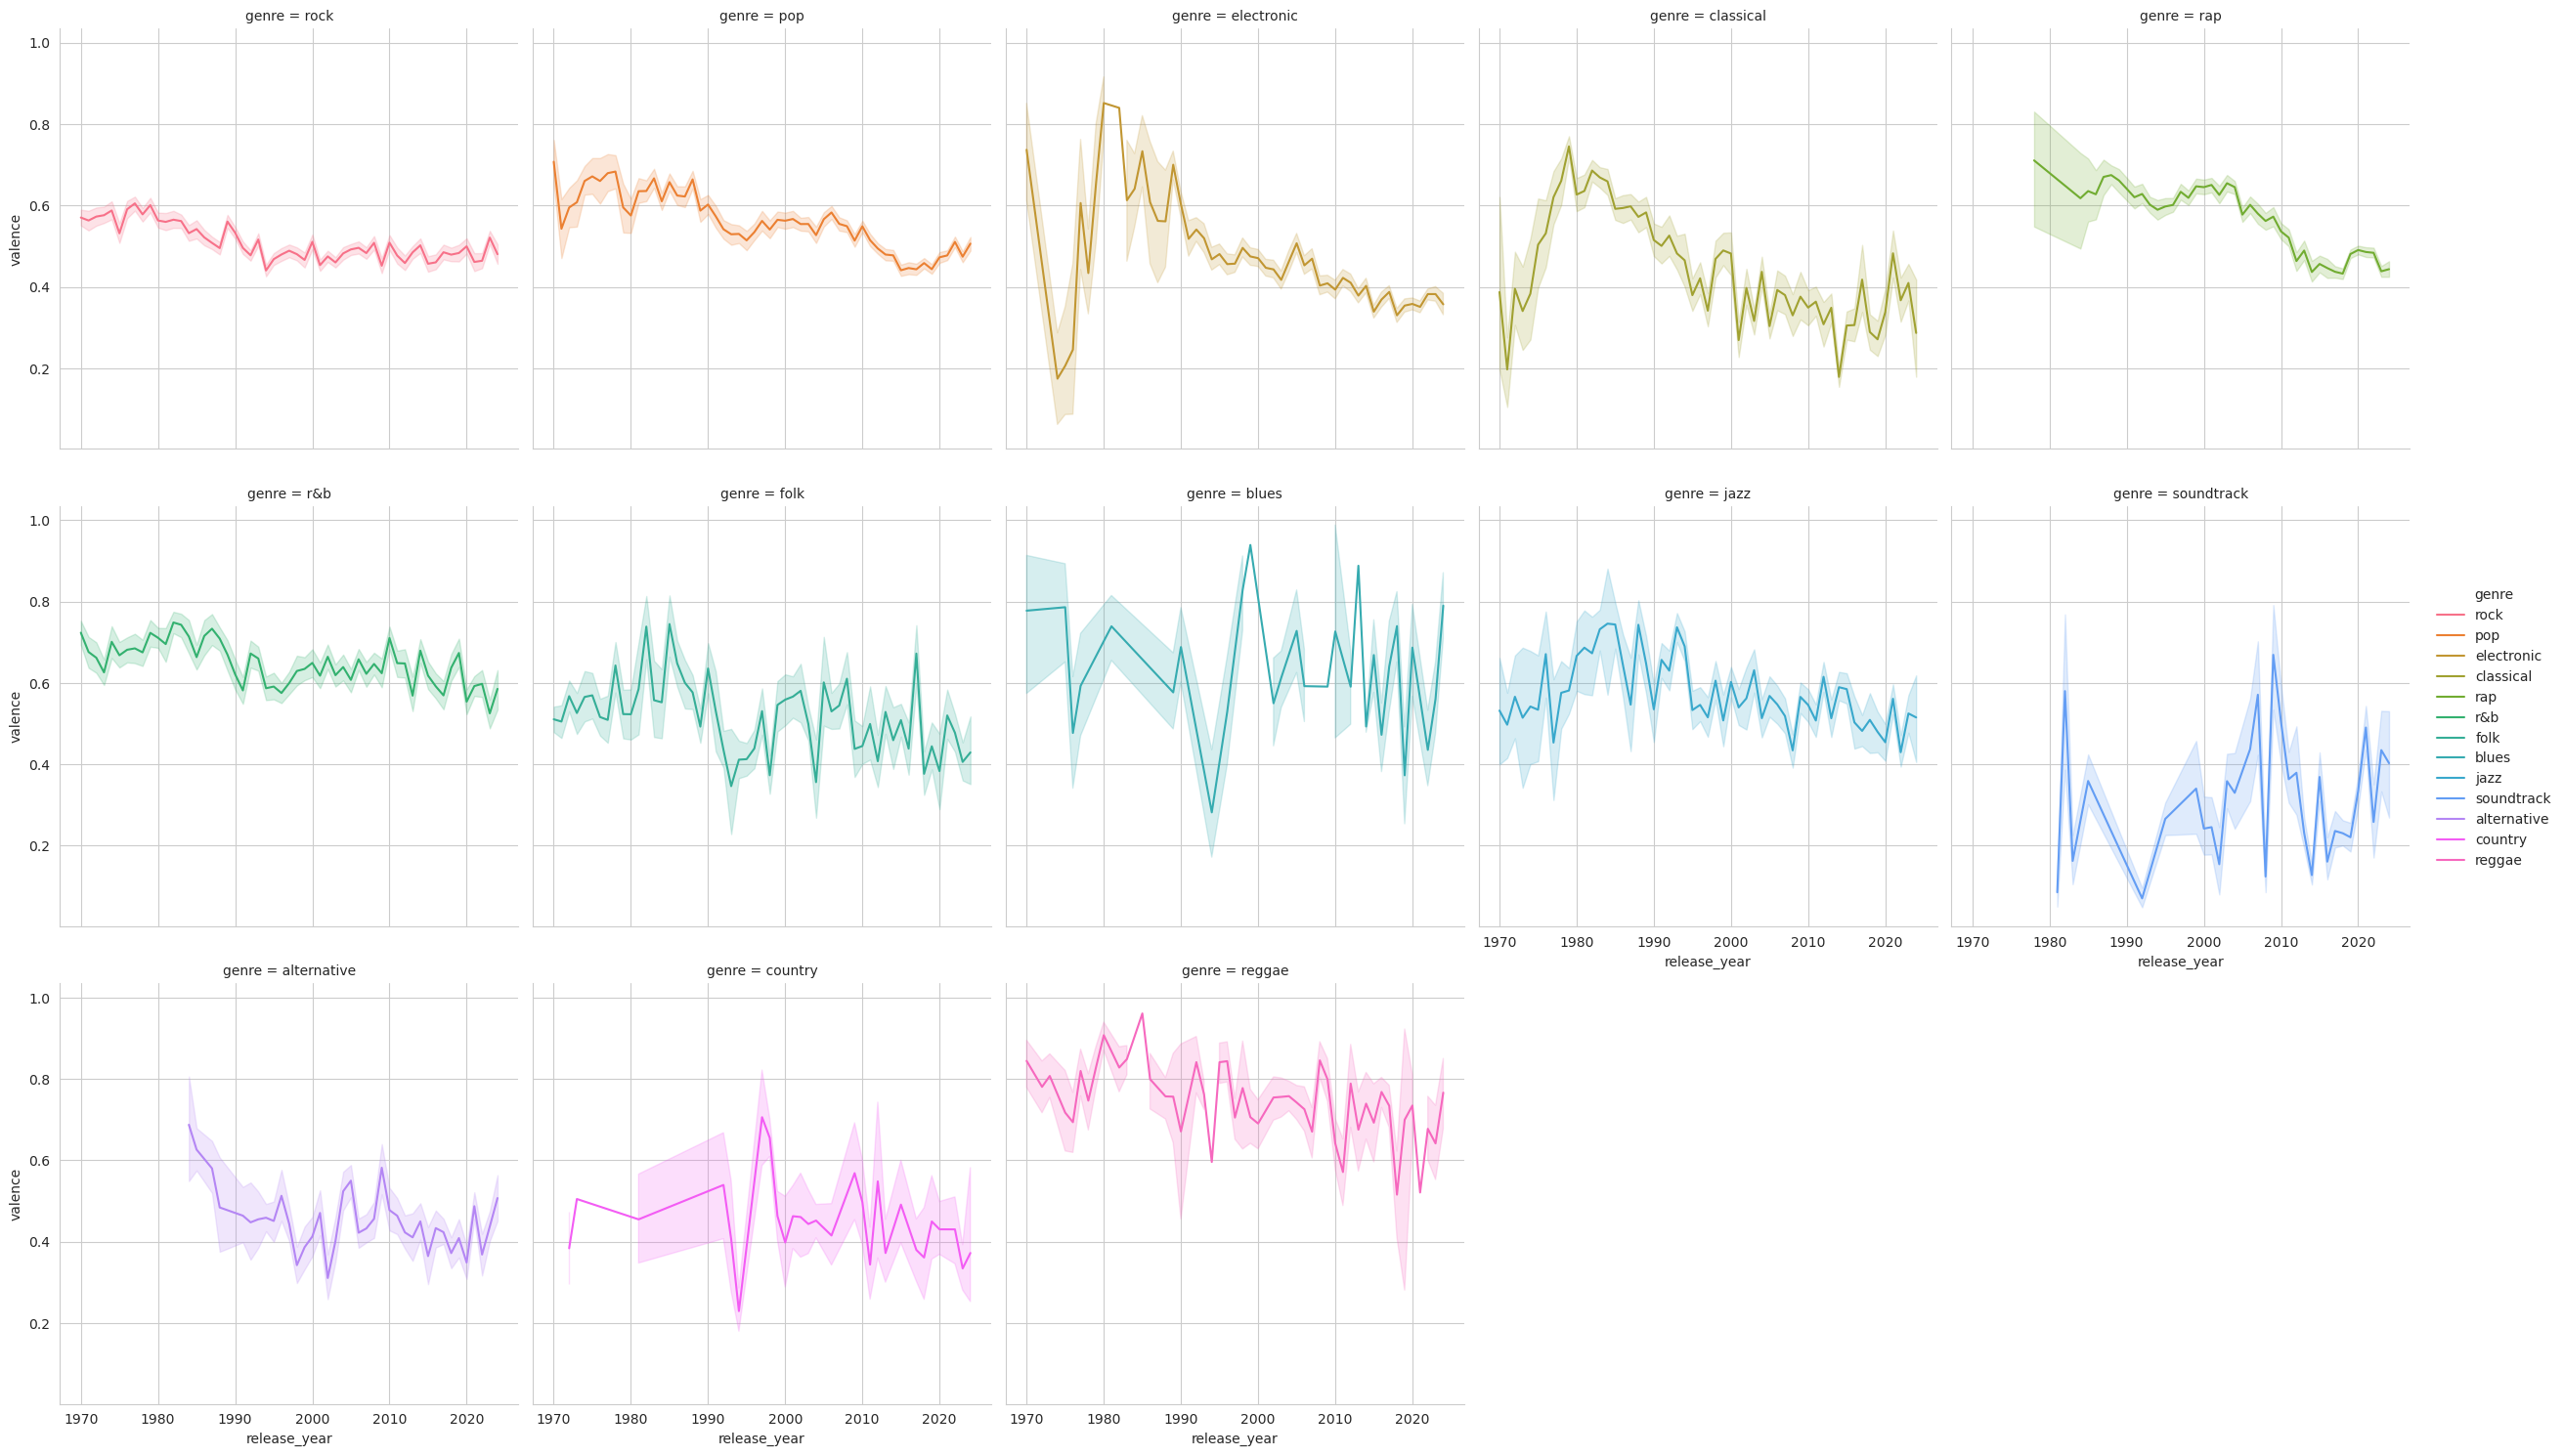

In [40]:
sns.relplot(data=df_1970, x="release_year", y="valence", col="genre", col_wrap=5, hue="genre", kind="line")
plt.show()

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

## The majority of the songs are released on Friday

Monday and Tuesday are also favourite artists weekdays.

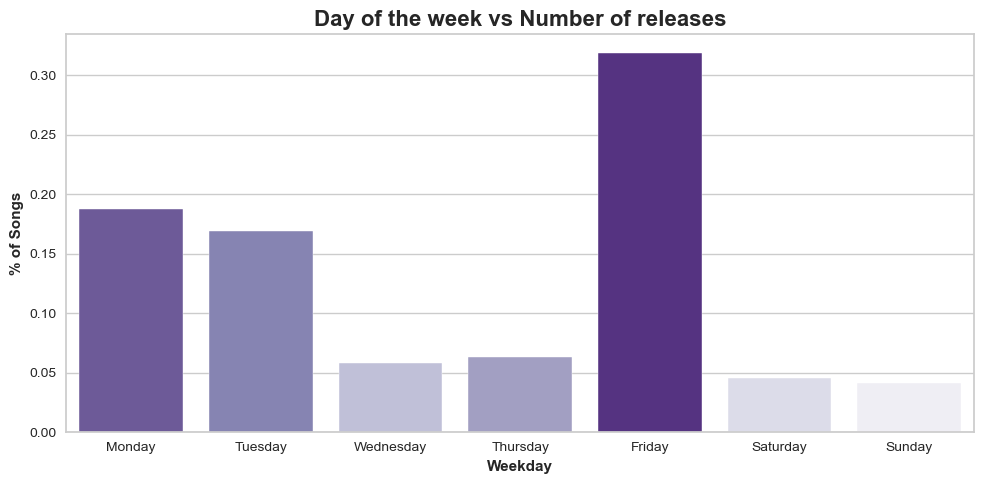

In [83]:
fig = plt.figure(figsize=(10, 5))

sns.countplot(data=df_1970, x="day_of_week",
              order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], hue="day_of_week",
              palette="Purples", hue_order=["Sunday", "Saturday", "Wednesday", "Thursday", "Tuesday", "Monday", "Friday"],
              legend=False, stat="proportion")
plt.title("Day of the week vs Number of releases", weight="bold", fontsize=16)
plt.xlabel("Weekday", weight="bold")
plt.ylabel("% of Songs", weight="bold")
plt.tight_layout()
plt.savefig("figures/days_releases.png")
plt.show()

---

In [29]:
features = ["acousticness", "danceability", "duration", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]

cluster_data = no_duplicates[features]
cluster_data = cluster_data[~cluster_data["energy"].isna()]

scaler = StandardScaler()

data_scaled = scaler.fit_transform(cluster_data)

In [31]:
pca = PCA(n_components=3)
pca.fit(data_scaled)

PCA_df = pd.DataFrame(data=pca.transform(data_scaled), columns=list("XYZ"))

In [33]:
pca.explained_variance_ratio_.sum() # 3D explains only about 54% of the variance, however It can be usefull to plot the clusters

0.5386412306689263

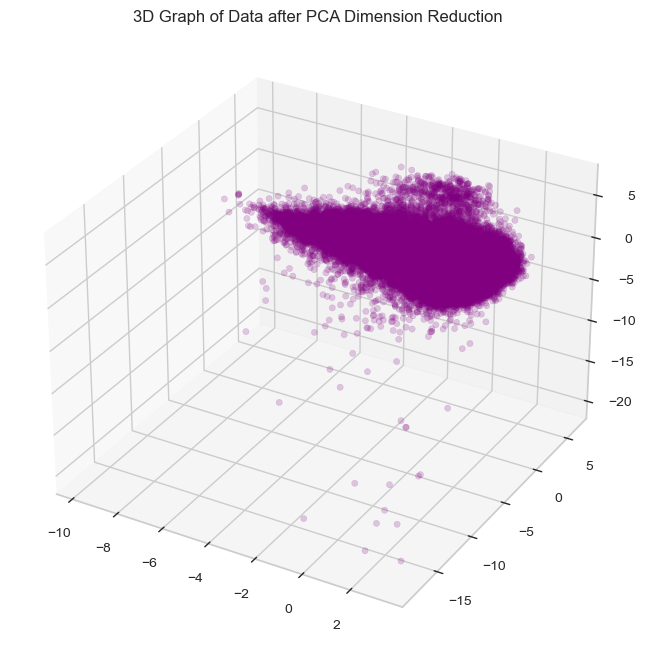

In [51]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(PCA_df["X"], PCA_df["Y"], PCA_df["Z"], c="purple", marker="o", alpha=0.2)
ax.set_title("3D Graph of Data after PCA Dimension Reduction")

plt.show()
fig.savefig("figures/data_3d.png")

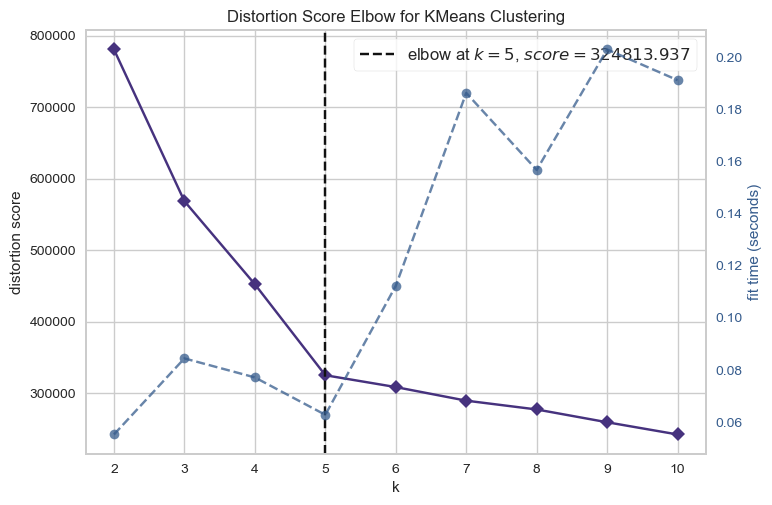

In [49]:
fig = plt.figure()

sns.set_palette("viridis")
elbow_viz = KElbowVisualizer(KMeans(), k=10)
elbow_viz.fit(PCA_df)
elbow_viz.show()

plt.show()
fig.savefig("figures/elbow_method.png")

In [38]:
clustering = KMeans(n_clusters=5, random_state=42)

y_km = clustering.fit_predict(PCA_df)

PCA_df["Cluster"] = y_km
cluster_data["Cluster"] = y_km

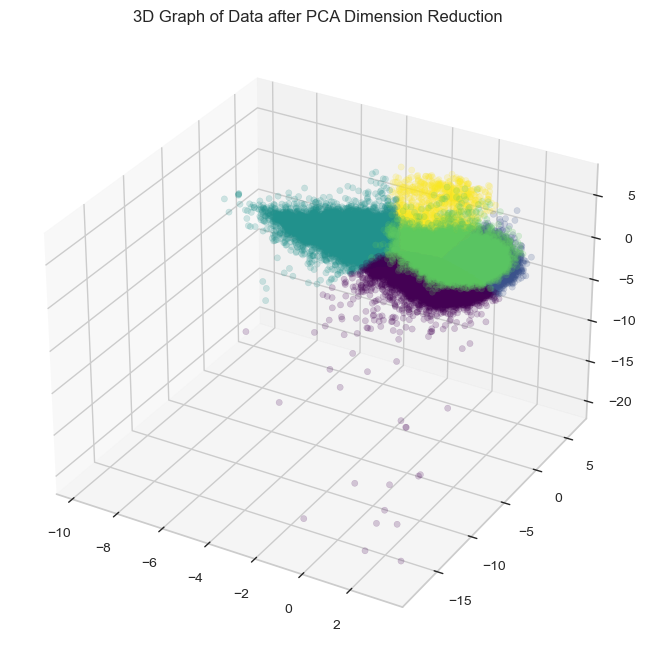

In [47]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(PCA_df["X"], PCA_df["Y"], PCA_df["Z"], c=PCA_df["Cluster"], marker="o", alpha=0.2, cmap="viridis")
ax.set_title("3D Graph of Data after PCA Dimension Reduction")

plt.show()
fig.savefig("figures/cluster_3d.png")

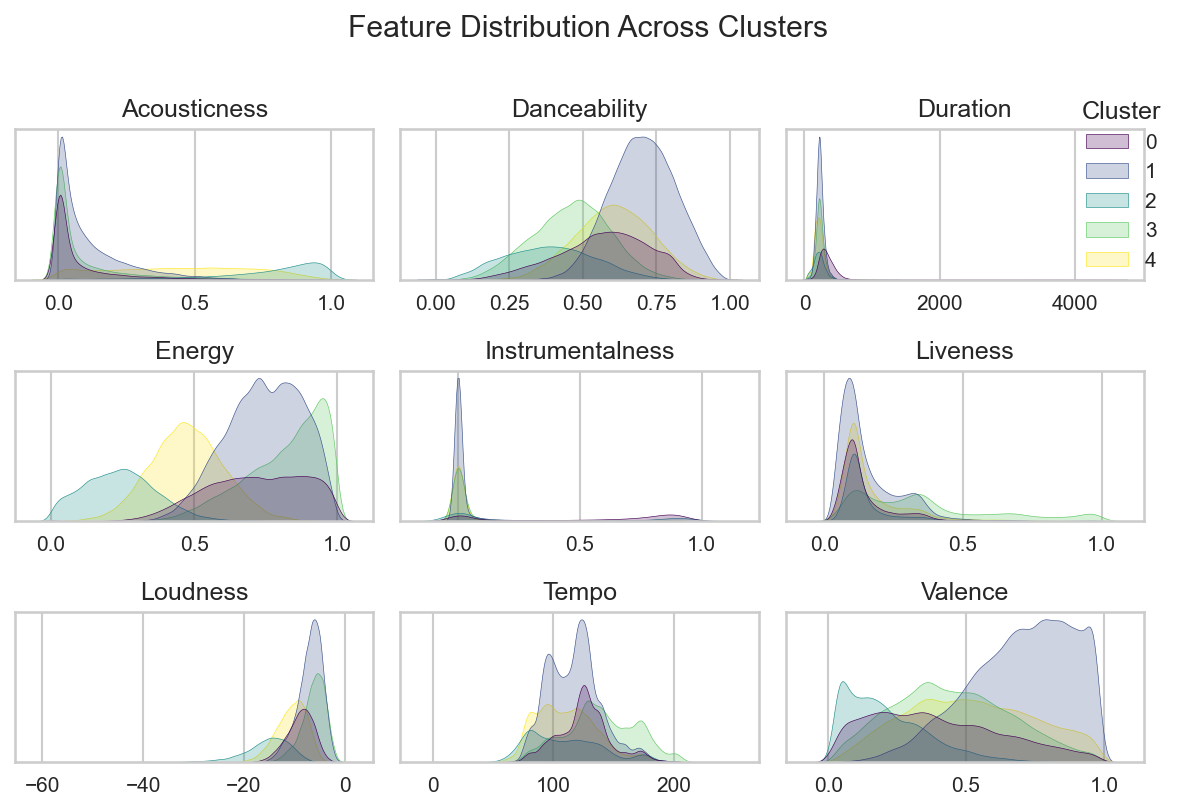

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=150)

columns = features.copy()
columns.remove("speechiness")

for ax, col in zip(axes.flatten(), columns):
    legend_flag = True if col == "duration" else False
    sns.kdeplot(data=cluster_data, x=col, hue="Cluster", fill=True, palette="viridis", multiple="layer", ax=ax, legend=legend_flag)
    ax.set_title(col.capitalize())
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_visible(False)
    if legend_flag:
        sns.move_legend(ax, "upper right", bbox_to_anchor=(1.1, 1.32))
    

fig.suptitle("Feature Distribution Across Clusters")
plt.tight_layout()
plt.show()
fig.savefig("figures/cluster_distribution.png")

<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Preparation for the lyrics analysis

Further analysis and the classification problem is presented in **lyrics-analysis.jpynb**.

In [237]:
lyrics = no_duplicates[~no_duplicates["lyrics"].isna()]
lyrics = lyrics[lyrics["genre"].isin(["pop", "rap", "rock", "r&b", "alternative", "electronic"])]

lyrics.to_csv("lyrics_data.csv", index=False)


In [45]:
no_duplicates.drop(["lyrics"], axis=1).to_csv("bipower_data.csv", index=False)

In [377]:
!git status

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   songs-EDA.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [379]:
!git add .

In [381]:
!git commit -m "clustering init"

[master a175d98] clustering init
 1 file changed, 157 insertions(+), 10 deletions(-)


In [383]:
!git push origin master

To github.com:milonpabis/songs-across-years.git
   dad0efb..a175d98  master -> master


<div style="background: rgb(232, 232, 255); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7);">

# Experimenting with the top songs

In [179]:
no_duplicates.groupby("release_year")

song_title song_release_date  featured  song_popularity  \
19826  She's so High        1999-02-23         0               71   

       acousticness  danceability  energy  instrumentalness  liveness  \
19826           0.2         0.537    0.84          0.000002    0.0998   

       loudness  ...  artist_popularity  artist_followers   album_name  \
19826    -4.626  ...               54.0           43395.0  Tal Bachman   

       album_total_tracks  album_popularity  \
19826                  12                62   

                                                  lyrics  genre  day_of_week  \
19826   She's blood, flesh, and bone No tucks or sili...   rock      Tuesday   

      release_year  duration  
19826         1999     224.0  

[1 rows x 26 columns]

In [207]:
no_duplicates[no_duplicates["song_popularity"] > 70].sort_values(by=["artist_popularity", "song_popularity"], ascending=True)[["song_title", "song_popularity", "artist_popularity", "artist_name"]].head(20)

song_title  song_popularity  \
19826                           She's so High               71   
3103                    Play That Funky Music               71   
4098          Born to Be Alive - The Original               71   
20978                          COULD BE WRONG               71   
30271                                 Rise Up               71   
35033                   Everyday Normal Guy 2               71   
32355               We Don't Talk About Bruno               72   
2007                                    Layla               71   
6544                          Break My Stride               71   
12011                      U Can't Touch This               71   
12339  DNA (Loving You) [feat. Hannah Boleyn]               71   
19849                            Closing Time               71   
29403                               Cool Kids               71   
33230                                    Grey               71   
954                                The Letter               72   
17037                             Coco Jamboo               72   
31693                               I See Red               73   
5928            Words - Original Version 1983               72   
15163                                      Ww               72   
1524       Spirit In The Sky - Deluxe Edition               73   

       artist_popularity                 artist_name  
19826               54.0                 Tal Bachman  
3103                55.0                 Wild Cherry  
4098                55.0           Patrick Hernandez  
20978               55.0                  LOSTBOYJAY  
30271               55.0                   Andra Day  
35033               55.0                  Jon Lajoie  
32355               55.0  Carolina Gaitán - La Gaita  
2007                56.0         Derek & The Dominos  
6544                56.0              Matthew Wilder  
12011               56.0                   MC Hammer  
12339               56.0               Billy Gillies  
19849               56.0                   Semisonic  
29403               56.0                   Echosmith  
33230               56.0                  Yung Filly  
954                 56.0                The Box Tops  
17037               56.0               Mr. President  
31693               56.0   Everybody Loves an Outlaw  
5928                57.0                  F.R. David  
15163               57.0               Other Nothing  
1524                57.0            Norman Greenbaum

In [209]:
no_duplicates[no_duplicates["song_popularity"]> 90].sort_values(by=["artist_popularity", "song_popularity"], ascending=True)[["song_title", "song_popularity", "artist_popularity", "artist_name"]].head(20)

song_title  song_popularity  \
33287                                  Belong Together               91   
33344                                       Stargazing               93   
33257                                 End of Beginning               94   
33320                               A Bar Song (Tipsy)               93   
33323                                        Gata Only               96   
33335                              MILLION DOLLAR BABY               94   
32479                                        As It Was               92   
33223                                 Beautiful Things               92   
33311                                 Good Luck, Babe!               94   
33343            I Had Some Help (Feat. Morgan Wallen)               96   
33186                             Please Please Please               98   
33317                                         Espresso              100   
33373                                          Houdini               94   
30213                                      Not Like Us               96   
33175   One Of The Girls (with JENNIE, Lily Rose Depp)               91   
33359                                          CHIHIRO               94   
33358                                            LUNCH               95   
279537                              BIRDS OF A FEATHER               98   
31257                                     Cruel Summer               92   
33324                    Fortnight (feat. Post Malone)               92   

        artist_popularity        artist_name  
33287                76.0         Mark Ambor  
33344                77.0        Myles Smith  
33257                77.0                Djo  
33320                81.0          Shaboozey  
33323                81.0         FloyyMenor  
33335                83.0      Tommy Richman  
32479                84.0       Harry Styles  
33223                85.0       Benson Boone  
33311                86.0      Chappell Roan  
33343                90.0        Post Malone  
33186                90.0  Sabrina Carpenter  
33317                90.0  Sabrina Carpenter  
33373                91.0             Eminem  
30213                92.0     Kendrick Lamar  
33175                93.0         The Weeknd  
33359                94.0      Billie Eilish  
33358                94.0      Billie Eilish  
279537               94.0      Billie Eilish  
31257               100.0       Taylor Swift  
33324               100.0       Taylor Swift

In [225]:
no_duplicates.sort_values(by="song_popularity", ascending=False).head(10000).sort_values(by="danceability", ascending=False)[["song_title", "song_popularity", "artist_popularity", "artist_name", "danceability"]].head(30)

song_title  song_popularity  \
2785                 Who Loves The Sun feat. Jo.Ke - Edit               67   
11811                                        Ice Ice Baby               69   
422                         Somethin' Here - Original Mix               61   
22723                                       Give It To Me               74   
270363                       Bad Bad Bad (feat. Lil Baby)               67   
20345                                            Trick Me               61   
25685                          SexyBack (feat. Timbaland)               79   
21093                                        GIRL LIKE ME               66   
30256                                            Bad Liar               63   
8889                                          It's Tricky               68   
241238                      Get Up (feat. Chamillionaire)               60   
29306                                            Anaconda               65   
28701                                          Shake That               73   
136046                                    They Wanna Fuck               60   
30649                                          Yes Indeed               77   
273228                                           Low Down               74   
25136                                     Push The Button               62   
274868                                           Verdansk               65   
269294                                           pad lock               63   
274428                                           Titanium               64   
34379                             Shake That - Radio Edit               61   
273868                            Cry Baby (feat. DaBaby)               64   
10087                                       Kingston Town               67   
276877                     SILVER TOOTH. (with A$AP Ferg)               62   
34683                                       Hey Sexy Lady               67   
17346                                    Around the World               71   
22072                                        Hot In Herre               76   
277675                                              CAIRO               76   
32850                                   PAINTING PICTURES               67   
34140   One Night In Bangkok - Radio Edit / From “Ches...               59   

        artist_popularity          artist_name  danceability  
2785                 58.0                   Nu         0.988  
11811                55.0          Vanilla Ice         0.979  
422                  47.0      Terrence Parker         0.979  
22723                77.0            Timbaland         0.975  
270363               82.0           Young Thug         0.974  
20345                62.0                Kelis         0.970  
25685                80.0    Justin Timberlake         0.967  
21093                79.0      Black Eyed Peas         0.965  
30256                80.0         Selena Gomez         0.965  
8889                 59.0           Run–D.M.C.         0.965  
241238               69.0                Ciara         0.964  
29306                85.0          Nicki Minaj         0.964  
28701                91.0               Eminem         0.963  
136046               74.0           Kim Petras         0.963  
30649                86.0             Lil Baby         0.963  
273228               86.0             Lil Baby         0.962  
25136                57.0            Sugababes         0.962  
274868               76.0                 Dave         0.961  
269294               88.0            21 Savage         0.959  
274428               76.0                 Dave         0.959  
34379                91.0               Eminem         0.957  
273868               82.0  Megan Thee Stallion         0.957  
10087                68.0                 UB40         0.957  
276877               61.0         Armani White         0.957  
34683                72.0               Shaggy       

In [239]:
no_duplicates.sort_values(by="song_popularity", ascending=False).head(10000).sort_values(by="valence", ascending=True)[["song_title", "song_popularity", "artist_popularity", "artist_name", "valence"]].head(30)

song_title  song_popularity  \
3894                                       Lovin' Feeling               70   
33839                                       Hello, Dolly!               66   
15163                                                  Ww               72   
33837                                   Souvenir d'Italie               66   
83655                                            S.T.A.Y.               61   
32013   Titanium (feat. Sia) - David Guetta & MORTEN F...               65   
21449                                      Be Your Friend               62   
257619                                            Oxygène               59   
31910                     Lo Vas A Olvidar (with ROSALÍA)               59   
33331                                    If We Being Rëal               84   
29112                                            Midnight               62   
13943                                             Falling               62   
263121                                                L$D               70   
257626                                             Excuse               59   
19505                                              Lonely               63   
4066                                You & Me - Rivo Remix               81   
194091                              Not My Responsibility               67   
8909                                        Raining Blood               66   
279543                                               BLUE               89   
20925                                      The Fight Song               62   
83648                                           Mountains               60   
262763                                              Jaded               66   
257617                                          Haggstrom               64   
257611                                                Key               68   
28917                                             Animals               67   
257631                                          Beginning               60   
263565                                                  9               60   
31806                                                  Ew               65   
194090                                     Halley's Comet               75   
264595                                    True Love Waits               60   

        artist_popularity      artist_name  valence  
3894                 58.0        French 79   0.0000  
33839                69.0  Louis Armstrong   0.0000  
15163                57.0    Other Nothing   0.0000  
33837                54.0   Lelio Luttazzi   0.0000  
83655                76.0      Hans Zimmer   0.0256  
32013                88.0     David Guetta   0.0305  
21449                52.0             XYSM   0.0312  
257619               71.0             C418   0.0313  
31910                94.0    Billie Eilish   0.0320  
33331                81.0             Yeat   0.0348  
29112                88.0         Coldplay   0.0349  
13943                54.0          Keanler   0.0350  
263121               83.0       A$AP Rocky   0.0352  
257626               71.0             C418   0.0352  
19505                55.0          VisionV   0.0355  
4066                 74.0       Disclosure   0.0356  
194091               94.0    Billie Eilish   0.0362  
8909                 65.0           Slayer   0.0363  
279543               94.0    Billie Eilish   0.0365  
20925                68.0   Marilyn Manson   0.0368  
83648                76.0      Hans Zimmer   0.0371  
262763               94.0            Drake   0.0371  
257617               71.0             C418   0.0374  
257611               71.0             C418   0.0376  
28917                74.0    Martin Garrix   0.0376  
257631               71.0             C418   0.0378  
263565               94.0            Drake   0.0379  
31806                77.0             Joji   0.0380  
194090               94.0    Billie Eilish   0.0381  
264595  

In [245]:
no_duplicates[no_duplicates["artist_name"] == "Ariana Grande"].sort_values(by="song_popularity").head(10)

song_title song_release_date  featured  \
30103               Beauty and the Beast        2017-02-10         1   
260170                Love Is Everything        2013-01-01         0   
268357              get well soon - live        2019-12-23         0   
260171                Snow In California        2013-01-01         0   
268358       in my head interlude - live        2019-12-23         0   
30694         the light is coming - live        2019-12-23         1   
271188          Nobody (with Chaka Khan)        2019-11-01         1   
268351          you'll never know - live        2019-12-23         0   
268361  my heart belongs to daddy - live        2019-12-23         0   
268353                       nasa - live        2019-12-23         0   

        song_popularity  acousticness  danceability  energy  instrumentalness  \
30103                25       0.12400         0.511   0.538          0.000000   
260170               34       0.09040         0.563   0.931          0.000000   
268357               38       0.33300         0.639   0.625          0.000000   
260171               38       0.25700         0.631   0.533          0.000000   
268358               38       0.04210         0.673   0.783          0.238000   
30694                38       0.00339         0.762   0.882          0.000326   
271188               38       0.04100         0.314   0.772          0.000000   
268351               39       0.06730         0.767   0.920          0.000002   
268361               39       0.13600         0.479   0.591          0.000001   
268353               39       0.20700         0.648   0.621          0.000027   

        liveness  loudness  ...  artist_popularity  artist_followers  \
30103     0.1050    -7.057  ...               91.0        97347801.0   
260170    0.2580    -3.468  ...               91.0        97347801.0   
268357    0.3980    -4.932  ...               91.0        97347801.0   
260171    0.3510    -5.965  ...               91.0        97347801.0   
268358    0.3520    -6.997  ...               91.0        97347801.0   
30694     0.2770    -3.814  ...               91.0        97347801.0   
271188    0.0847    -4.406  ...               91.0        97347801.0   
268351    0.3750    -3.445  ...               91.0        97347801.0   
268361    0.4630    -9.129  ...               91.0        97347801.0   
268353    0.9180    -5.831  ...               91.0        97347801.0   

                                               album_name  album_total_tracks  \
30103   Piękna i Bestia (Ścieżka dźwiękowa polskiej we...                  52   
260170                                   Christmas Kisses                   4   
268357                           k bye for now (swt live)                  32   
260171                                   Christmas Kisses                   4   
268358                           k bye for now (swt live)                  32   
30694                            k bye for now (swt live)                  32   
271188  Charlie's Angels (Original Motion Picture Soun...                  11   
268351                           k bye for now (swt live)                  32   
268361                           k bye for now (swt live)                  32   
268353                           k bye for now (swt live)                  32   

        album_popularity lyrics  genre  day_of_week release_year  duration  
30103                 36    NaN    pop       Friday         2017     227.0  
260170                46    NaN    pop      Tuesday         2013     212.0  
268357                58    NaN    pop       Monday         2019     207.0  
260171                46    NaN    pop      Tuesday         2013     206.0  
268358                58    NaN    pop       Monday         2019     150.0  
30694                 58    NaN    pop       Monday         2019     130.0  
271188                61    NaN    pop       Friday         2019     180.0  
268351                58    NaN    pop      